In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import zarr
from pyTMD.io import ATLAS
from pyTMD.interpolate import extrapolate #, spline
#from pyTMD.io import read_netcdf_elevation, read_netcdf_transport, read_netcdf_grid #not work for read_netcdf_grid
from datetime import datetime, timedelta, timezone
import netCDF4, pathlib


In [2]:
from src.model_utils import *
from src.model_plot import *
from src.pytmd_utils import * #extend_array, extend_matrix #Note that read_xxx changed to use lib

In [3]:
# Unload the module if needed
import importlib, sys
if 'src.model_utils' in sys.modules:
    print("Module in it!")
    #del sys.modules['src.model_utils']
    importlib.reload(sys.modules['src.model_utils']) 

from src.model_utils import *

Module in it!


In [3]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'ATLAS-netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5-nc'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)
print(tpxo9_atlas_v5.grid_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc


In [4]:
#Global variable 
global_grid = True
xChunkSz = 15
yChunkSz = 15
grid_sz = 1/30
chunk_file = 'data/tpxo9_chunks.zarr'

In [5]:
#if tpxo9_atlas_v5:
model_files= tpxo9_atlas_v5.model_file
#print(model_files)
#for i, model_file in enumerate(model_files):
model_file = pathlib.Path(model_files[7]).expanduser()
#model_file = pathlib.Path(model_file).expanduser()
hcz, cons = read_netcdf_elevation(model_file, compressed=False)
#print(hcz.mask.shape)
print(np.where(hcz.mask))

(array([], dtype=int64), array([], dtype=int64))


In [ ]:
#Check model file NA value location
tmp_mask = np.copy(hcz.mask)
tmp_mask[hcz.data==0j] = True
print(np.where(tmp_mask))
plot_model_mask(tmp_mask)

In [5]:
#I don't know why it's not work by directly import from pyTMD lib.
# TypeError: read_netcdf_grid() got an unexpected keyword argument 'variable'
lonz, latz, bathy_z = read_netcdf_grid(tpxo9_atlas_v5.grid_file, variable='z')
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
print(bathy_z.shape)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
(5401, 10800)


In [ ]:
""" #read_netcdf_grid in ATLAS.py
fileID = netCDF4.Dataset(tpxo9_atlas_v5.grid_file, 'r')
# read latitude and longitude at z-nodes
lonz = fileID.variables['lon_z'][:].copy()
latz = fileID.variables['lat_z'][:].copy()
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)

bathy_z = np.ma.zeros((ny,nx))
bathy_z.data[:,:] = fileID.variables['hz'][:,:].T
bathy_z.mask = (bathy_z.data == 0.0)
fileID.close()
"""

In [6]:
def extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat,
                  tide_model, type, constituents, chunk_num):
    print('model type-chunk is: ', type, '-', chunk_num)
    if type in ['u', 'v']:
        model_files = tide_model.model_file[type]
    else:
        model_files = tide_model.model_file

    lon_chunk = lon[start_lon:end_lon]
    lat_chunk = lat[start_lat:end_lat]
    lon_grid, lat_grid = np.meshgrid(lon_chunk, lat_chunk)

    # if type == 'z':
    #if constituents is None:
    #    constituents = ATLAS.read_constants(
    #        tide_model.grid_file, model_files, type=type, compressed=tide_model.compressed)

    #amp, ph, D = ATLAS.interpolate_constants(
    #    lon_grid.ravel(), lat_grid.ravel(),
    #    constituents, type=type, scale=tide_model.scale,
    #    method='spline', extrapolate=True)
    # c = constituents
    # else:
    amp, ph, D, c = ATLAS.extract_constants(
            lon_grid.ravel(), lat_grid.ravel(),
            tide_model.grid_file,
            model_files, type=type, method='spline',
            scale=tide_model.scale, compressed=tide_model.compressed)
    #c = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
    #     's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
    chunkx = end_lon - start_lon  # slicing is not include end_lon
    chunky = end_lat - start_lat
    amplitude = np.reshape(amp, (chunky, chunkx, len(c)))
    phase = np.reshape(ph, (chunky, chunkx, len(c)))
    return amplitude, phase #, constituents

In [8]:
def filter_and_form_clusters(coords_to_recompute):
    coords_to_recompute = set(coords_to_recompute)  # Ensure it's a set for efficient removal
    clusters = []

    while coords_to_recompute:
        ilat_idx, ilon_idx = next(iter(coords_to_recompute))  # Take one coord from the set without removing it

        neighbors = [(ilat_idx + dlat, ilon_idx + dlon) for dlat in range(5) for dlon in range(5)]

        if all(neighbor in coords_to_recompute for neighbor in neighbors):
            start_lat, start_lon = min(neighbors, key=lambda x: (x[0], x[1]))
            end_lat, end_lon = max(neighbors, key=lambda x: (x[0], x[1]))
            # +1 because we want to include the last point when slicing
            clusters.append((start_lat, end_lat + 1, start_lon, end_lon + 1))

            for neighbor in neighbors:
                coords_to_recompute.discard(neighbor)  # Remove these neighbors from further consideration
        else:
            coords_to_recompute.discard((ilat_idx, ilon_idx))  # Remove the current point if not all its neighbors are in the set

    return clusters


def process_neighbors(cluster, lonz, latz, tpxo_model, var_type, cluster_idx, cluster_num):
    start_lat, end_lat, start_lon, end_lon = cluster
    lon_chunk = lonz[start_lon:end_lon]
    lat_chunk = latz[start_lat:end_lat]
    lon_grid, lat_grid = np.meshgrid(lon_chunk, lat_chunk)

    amp, ph, D, c = ATLAS.extract_constants(
        lon_grid.ravel(), lat_grid.ravel(),
        tpxo_model.grid_file,
        tpxo_model.model_file[var_type], type=var_type, method='spline',
        scale=tpxo_model.scale, compressed=tpxo_model.compressed)

    # reshape back amp and ph
    amp = amp.reshape((end_lat - start_lat, end_lon - start_lon, -1))
    ph = ph.reshape((end_lat - start_lat, end_lon - start_lon, -1))
    print(f"Cluster index: {cluster_idx}/{cluster_num} for variable: {var_type}")

    return (cluster_idx, cluster_num, start_lat, end_lat, start_lon, end_lon, var_type, amp, ph)


In [9]:
def save_to_zarr(amplitude, phase, constituents, amp_var, ph_var, lon, lat, output_file, group_name, mode='write_chunk'):
    # Check if the group exists in the Zarr file
    if mode == 'append_chunk':
        ds = xr.open_zarr(output_file, group=group_name)
        
        # Append new data variables
        ds[amp_var] = (['lat', 'lon', 'constituents'], amplitude)
        ds[ph_var] = (['lat', 'lon', 'constituents'], phase)
    else:    
    #except ValueError:  # If group does not exist, create a new dataset 
        ds = xr.Dataset({
            amp_var: (['lat', 'lon', 'constituents'], amplitude),
            ph_var: (['lat', 'lon', 'constituents'], phase)
        }, coords={
            'lon': lon,
            'lat': lat,
            'constituents': np.array(constituents, dtype=str)
        })

    ds.to_zarr(output_file, mode='a', group=group_name) 

''' Not really execute this to prevent very large loop if find many NA for 5x5 neighbors
            nan_coords = np.argwhere(np.isnan(amp.data))
            valid_nan_coords = [
                (start_lat + i, start_lon + j) for i, j, k in nan_coords 
                if not bathymetry.mask[start_lat + i, start_lon + j] 
                   and bathymetry.data[start_lat + i, start_lon + j] > 0.0
            ]

            clusters_to_recompute = filter_and_form_clusters(valid_nan_coords)

            for cluster_idx, cluster in enumerate(clusters_to_recompute):
                result = process_neighbors(cluster, lon, lat, tpxo_model, type, cluster_idx, len(clusters_to_recompute))
                proc_cluster_idx, proc_cluster_num, start_lat_cluster, end_lat_cluster, start_lon_cluster, end_lon_cluster, proc_type, new_amp, new_ph = result
    
                # Replace NaN values in original amp and ph with recomputed values
                for i, j in valid_nan_coords:
                    local_i = i - start_lat_cluster
                    local_j = j - start_lon_cluster
        
                    if np.isnan(amp[i, j]).any():
                        amp[i, j] = new_amp[local_i, local_j]
            
                    if np.isnan(ph[i, j]).any():
                        ph[i, j] = new_ph[local_i, local_j]
'''

def tpxo2zarr(lon, lat, bathymetry, amp_var, ph_var, tpxo_model, 
              chunk_size_lon=45, chunk_size_lat=45, grid_sz=1/30, 
              chunk_file='chunks.zarr', type=None, mode='write_chunk', 
              global_grid=False, en_interpolate=False, interpolate_to=None,
              constituents=None):
    if (global_grid):
        lon_range = range(0, len(lon), int(chunk_size_lon/grid_sz))
        lon_range = list([x + 1 for x in lon_range]) 
    else: 
        lon_range = list(range(0, len(lon), int(chunk_size_lon/grid_sz)))
        if len(lon) not in lon_range:  # Ensure last element is included if it's not already
            lon_range.append(len(lon))

    lat_range = range(0, len(lat), int(chunk_size_lat/grid_sz))
    lat_range = list([x + 1 if x==5400 else x for x in lat_range]) #lat length is 5401 not 5400
    if len(lat) not in lat_range:  
        lat_range.append(len(lat))

    cnt_chunk = 0
    # if no chunk in longitude
    # start_lon = 1 if global_grid else 0 # extend_array will also extend first index
    # end_lon = len(lon)-1 if global_grid else len(lon) #chunk lon[0:100] will not include 100, but here lon is expand_array:10801 so do len(lon)-1
    # loop over each chunk
    for lat_idx in range(len(lat_range) - 1):
        for lon_idx in range(len(lon_range) -1):
            start_lon = lon_range[lon_idx] #handle in lon_range #lon_range[lon_idx]+1 if global_grid else lon_range[lon_idx]
            end_lon = lon_range[lon_idx+1] #handle in lon_range #lon_range[lon_idx+1]+1 if global_grid else lon_range[lon_idx+1]
            start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]      
            print(lon[start_lon], lon[end_lon-1], lat[start_lat], lat[end_lat-1], cnt_chunk)
            # Extract amplitude and phase for the current chunk
            amp_chunk, ph_chunk = extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, #bathymetry, 
                                                tpxo_model, type,
                                                constituents, cnt_chunk) #, global_grid, en_interpolate, interpolate_to)
            amp_chunk[amp_chunk.mask] = np.nan
            ph_chunk[ph_chunk.mask] = np.nan
            amp = amp_chunk.data
            ph = ph_chunk.data

            if en_interpolate and interpolate_to is not None:
                glon, glat, gbathy = interpolate_to
                if global_grid:
                    lon_chunk = glon[(start_lon-1):(end_lon-1)] 
                else:
                    lon_chunk = glon[start_lon:end_lon]
                lat_chunk = glat[start_lat:end_lat]
            else:
                lon_chunk = lon[start_lon:end_lon]
                lat_chunk = lat[start_lat:end_lat]
            
            group_name = f"chunk_{cnt_chunk}"
            c = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
                 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
            save_to_zarr(amp, ph, c, amp_var, ph_var, lon_chunk, lat_chunk, chunk_file, group_name, mode)
            cnt_chunk += 1

    return cnt_chunk    
                

In [6]:
# Adjust longitude and lat values as per convention
lonzx = lonz #already in [0,360] # adjust_lon_lat(lonz, lonz)
    
# Determine if it's a global grid
dlon = lonzx[1] - lonzx[0]
global_grid = True # np.isclose(lonzx[-1] - lonzx[0], 360.0 - dlon)
if global_grid:
    lonzx = extend_array(lonzx, dlon)
    bathy_zx = extend_matrix(bathy_z)
    
# create masks
bathy_zx.mask = (bathy_zx.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonzx, latz)
#Dz = spline_2d(lonzx, latz, bathy_zx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(len(lonz))
print(bathy_z.shape)
print('----after extend----')
print(len(lonzx))
print(bathy_zx.shape)

10800
(5401, 10800)
----after extend----
10802
(5401, 10802)


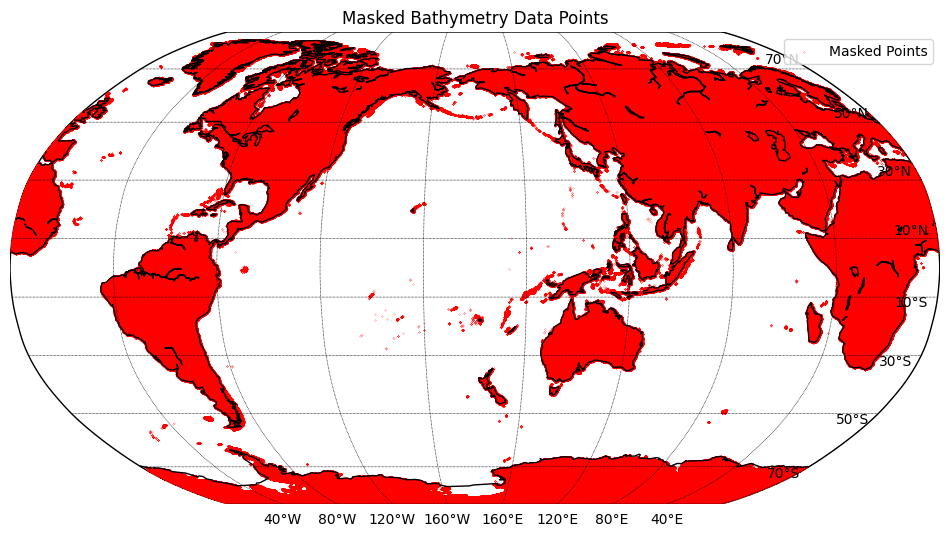

In [14]:
plot_model_mask(bathy_zx[:,1:10801].mask)

In [8]:
#Global variable Test
print(lonz[5398:5402]) #try chunk not crossing 180 degree to avoid interpolation error??
print(latz[2698:2702])

lon_range = list(range(0, len(lonz), int(xChunkSz/grid_sz)))
##lon_range = list([x - 1 for x in lon_range]) # to not crossing 180 #slicing not include end
if len(lonz) not in lon_range:  # Ensure last element is included if it's not already
    lon_range.append(len(lonz))
print(lon_range)

lat_range = range(0, len(latz), int(yChunkSz/grid_sz))
lat_range = list([x + 1 if x==5400 else x for x in lat_range]) #lat length is 5401 not 5400
if len(latz) not in lat_range: 
    lat_range.append(len(latz))
print(lat_range)

lon_extend = range(0, len(lonzx), int(xChunkSz/grid_sz))
lon_extend = list([x + 1 for x in lon_extend]) 
#if len(lonzx) not in lon_extend:  
#    lon_extend.append(len(lonzx))
print(lon_extend)
print([lonzx[x] for x in lon_extend])
print(lonz[0], lonz[-1])

[179.96666463 179.99999797 180.0333313  180.06666463]
[-0.06666667 -0.03333333  0.          0.03333333]
[0, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5400, 5850, 6300, 6750, 7200, 7650, 8100, 8550, 9000, 9450, 9900, 10350, 10800]
[0, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5401]
[1, 451, 901, 1351, 1801, 2251, 2701, 3151, 3601, 4051, 4501, 4951, 5401, 5851, 6301, 6751, 7201, 7651, 8101, 8551, 9001, 9451, 9901, 10351, 10801]
[0.033333334014147384, 15.033333164435826, 30.033332994857506, 45.03333282527918, 60.03333265570086, 75.03333248612255, 90.03333231654422, 105.0333321469659, 120.03333197738758, 135.03333180780928, 150.03333163823095, 165.03333146865262, 180.03333129907432, 195.033331129496, 210.03333095991766, 225.03333079033936, 240.03333062076103, 255.0333304511827, 270.0333302816044, 285.0333301120261, 300.0333299424477, 315.0333297728694, 330.0333296032911, 345.03332943371277, 360.03332926413447]
0.033333334014147384 359.99999593117

In [11]:
if False: #global_grid: #bathymetry_z need not interpolate
    bathy = bathy_zx
    lonx = lonzx
    #lat_chunk = yChunkSz
    en_interpolate = True
else: 
    bathy = bathy_z
    lonx = lonz
    #lat_chunk = 180 #must sync with u, v
    en_interpolate = False
print(bathy.shape)
percentiles = [33.14, 33.1425, 33.15, 33.25, 33.3, 33.4, 33.5, 34, 35, 37.5, 40, 50, 75, 90, 99]
mvalues = np.percentile(bathy.data, percentiles)

# Print the results
for p, v in zip(percentiles, mvalues):
    print(f"{p}th percentile: {v}")

smallz_indx = np.where((bathy.data < 2) & (bathy.data > 0)) #1.0316635131838137*10
print(bathy.data[smallz_indx].shape)
#print(bathy.data[smallz_indx])


(5401, 10800)
33.14th percentile: 0.0
33.1425th percentile: 1.0
33.15th percentile: 2.0
33.25th percentile: 3.9465345734357937
33.3th percentile: 5.0
33.4th percentile: 7.494790409087727
33.5th percentile: 9.997455587387101
34th percentile: 20.0
35th percentile: 40.44055137634274
37.5th percentile: 114.0
40th percentile: 253.1468383789063
50th percentile: 2515.1793212890625
75th percentile: 4281.35986328125
90th percentile: 5062.09033203125
99th percentile: 5824.58056640625
(1708,)


In [13]:
#constituents = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
#                's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']

constituents = ATLAS.read_constants(
            tpxo9_atlas_v5.grid_file, model_files, type='z', 
            compressed=tpxo9_atlas_v5.compressed)
print(constituents)

q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm


In [ ]:
# Doing bathy_z need not interpolate, but lat_chunk must sync with doing u, v
# must rm -rf xx_chunks.zarr/

chunkz = tpxo2zarr(lonz, latz, bathy_z, 'z_amp', 'z_ph',  tpxo9_atlas_v5, 
                   xChunkSz, yChunkSz, grid_sz=1/30, chunk_file=chunk_file, 
                   type='z', mode='write_chunk', global_grid=False, 
                   en_interpolate=False, interpolate_to=None,
                   constituents=constituents)
print(chunkz)

In [11]:
#Temporarily test, concate by lat axis, if no chunks in lon axis
# ds_combined = xr.concat([xr.open_zarr(chunkz_file, group=f"chunk_{i}") for i in range(chunkz)], dim='lat')
# chunk_size = 338
# ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
# ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)

# This approach assumes that each chunk has the same size, except perhaps the last one in each dimension. It takes the chunks, organizes them in their proper 2D sequence, and then concatenates them in the correct order.
num_lat_chunks = len(lat_range) - 1
num_lon_chunks = len(lon_range) - 1

# 1. Organize the chunks into a 2D matrix
chunks_matrix = [[xr.open_zarr(chunk_file, group=f"chunk_{lat_idx*num_lon_chunks + lon_idx}") 
                  for lon_idx in range(num_lon_chunks)] 
                  for lat_idx in range(num_lat_chunks)]

# 2. Concatenate the chunks

# Concatenate chunks along the longitude for each latitude band
concat_along_lon = [xr.concat(lon_chunks, dim='lon') for lon_chunks in chunks_matrix]

# Now, concatenate the results along the latitude
ds_combined = xr.concat(concat_along_lon, dim='lat')

chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


In [ ]:
#ds0 = xr.open_zarr('bak/tpxo9.zarr')
#print(ds0)

In [ ]:
#ds1 = xr.open_zarr('/tpxo9_fillna01.zarr')
#print(ds1)
#print(ds1.info)

In [42]:
#ds1['z_amp'].values=ds0['h_amp'].values
#ds1['z_ph'].values=ds0['h_ph'].values

In [ ]:
#dz = ds1
#print(dz)

In [26]:
#ds1.to_zarr('tpxo9_fillna01.zarr', mode='w')
zarr.convenience.consolidate_metadata('../data/tpxo9_fillna13.zarr')

<zarr.hierarchy.Group '/'>

In [5]:
dz = xr.open_zarr('../data/tpxo9.zarr', chunks='auto', decode_times=False, consolidated=True) #, consolidated=True) #, group="data_group") #, consolidated=False)
print(dz)

DEPRECATION: Loading egg at /home/bioer/.pyenv/versions/3.12.5/envs/py312numpy1/lib/python3.12/site-packages/src-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


<xarray.Dataset> Size: 42GB
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 43kB -90.0 -89.97 -89.93 ... 89.93 89.97 90.0
  * lon           (lon) float64 86kB 0.03333 0.06667 0.1 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>


In [9]:
cons = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
        's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
lon0 = 126
lat0 = 12.6
tol = 0.25
start_date = pd.to_datetime("2024-03-07T00:00:00.000Z")
end_date = pd.to_datetime("2024-03-10T00:00:00.000Z")
tide_time, dtime = get_tide_time(start_date, end_date)
#print(tide_time)
dsubx = dz.sel(lon=lon0, lat=lat0, method="nearest", tolerance=tol)
ts = get_tide_series(dsubx["z_amp"].values, dsubx["z_ph"].values,
                     cons, tide_time, format="netcdf", unit="cm", drop_mask=True)
print(ts)

[  -4.69087526  -14.09581204  -14.73304025   -5.83603656   10.62254606
   30.37692203   47.87352934   57.62507114   55.63664051   40.57437449
   14.34337839  -18.15740496  -50.11704122  -74.47453108  -85.70068262
  -81.19946743  -61.9620433   -32.33826292    0.98342608   30.53898327
   49.85668324   55.04527721   45.81373274   25.61157726    0.77429412
  -21.15424111  -33.47317777  -32.16194511  -16.98417491    8.42066341
   37.44012227   62.12884514   75.1936901    71.8822499    51.33784026
   17.05060821  -23.79771319  -62.01714485  -88.71794059  -97.60835947
  -86.62570137  -58.45686222  -19.85003925   20.05314834   51.93030763
   68.52808713   66.45392949   47.08129648   16.28367935  -17.0302795
  -43.26397403  -54.73396372  -47.77265958  -23.72634559   11.39976346
   48.492942     77.63281794   90.57362914   82.85544425   55.0679442
   12.92058594  -34.00169194  -74.58159128  -99.03165888 -101.47008135
  -81.45707005  -44.07129662    1.43324195   43.96370302   73.30349233
   82.58

In [10]:
print(dsubx["z_amp"].values)
print(dsubx["z_ph"].values)

ph = dsubx["z_ph"].values
amp = dsubx["z_amp"].values
cph = -1j * ph * np.pi / 180.0
print("cph: ", cph)
# calculate constituent oscillation
hc = (amp * np.exp(cph))[np.newaxis, :]
print("hc: ", hc)
# Create a mask where values are NA or 0
mask = np.isnan(hc) ##| (hc == 0)
# Convert hc to a masked array
hc1 = ma.array(hc, mask=mask)


[0.02594224 0.12553884 0.05393515 0.16868906 0.10331021 0.53922632
 0.001      0.22839659 0.06224147 0.00223607 0.001      0.
 0.0116619  0.00948683 0.00632456]
[ 62.44719015  67.52056587  79.31508679  79.75591403 274.44123921
 287.59489265  -0.         315.17738559 313.69804516 333.43494911
  90.0000025   -0.         239.03624331  18.43494865  18.43494865]
cph:  [0.-1.08990908j 0.-1.17845619j 0.-1.38430941j 0.-1.3920033j
 0.-4.78990323j 0.-5.01947779j 0.+0.j         0.-5.50088311j
 0.-5.47506375j 0.-5.8195377j  0.-1.57079637j 0.+0.j
 0.-4.17196948j 0.-0.32175055j 0.-0.32175055j]
hc:  [[ 1.19999993e-02-0.023j       4.80000005e-02-0.116j
   1.00000008e-02-0.053j       2.99999945e-02-0.16599999j
   7.99999634e-03+0.103j       1.62999986e-01+0.51400003j
   1.00000000e-03+0.j          1.62000004e-01+0.161j
   4.29999992e-02+0.045j       2.00000003e-03+0.001j
  -4.37113900e-11-0.001j       0.00000000e+00+0.j
  -5.99999982e-03+0.01j        8.99999967e-03-0.003j
   6.00000008e-03-0.002j     ]

In [72]:
print(hc1)

[[(0.011999999635054428-0.02200000102120869j)
  (0.04699999749317068-0.11500000034576638j)
  (0.008999999784598207-0.05300000021417088j)
  (0.030000001599346664-0.16499999469971083j)
  (0.007999996817089435+0.1020000034406444j)
  (0.1629999941953366+0.5130000317559632j) (0.001+0j)
  (0.16199999857589983+0.16200000565714515j)
  (0.042999999159888044+0.04500000252317617j)
  (0.00200000003437657+0.001000000004657889j)
  (-4.3711390001862415e-11-0.000999999999999999j)
  (-4.3711390246791777e-11+0.000999999999999999j)
  (-0.005999999817746913+0.009999999633146238j)
  (0.008999999665577607-0.0029999998591811834j)
  (0.006000000078630037-0.002000000006646887j)]]


In [73]:
from pyTMD import predict
DELTAT = np.zeros_like(tide_time)

# Predict tide
tide = predict.time_series(
        tide_time, hc1, cons, deltat=DELTAT, corrections="netcdf")
minor = predict.infer_minor(
        tide_time, hc1, cons, deltat=DELTAT, corrections="netcdf")
print(tide)
print(minor) 

[-0.06904726921323538 -0.1831115180626235 -0.2049075007668637
 -0.12280013191849944 0.046096444782740685 0.2592802203980089
 0.45839741381727855 0.5834175569909376 0.5885590387110792
 0.4558466909049646 0.20202806049966965 -0.12385406217714191
 -0.4519914813834239 -0.709173853991744 -0.837000360509399
 -0.8061354615964232 -0.6233916075448017 -0.33040350036588206
 0.005670327004727965 0.3076486937172582 0.5069653198909626
 0.5611544903611968 0.4653881108665901 0.25426897751190414
 -0.007240203726850853 -0.24140243702003264 -0.3787017388105622
 -0.37629716153343135 -0.22918577908195054 0.028294760496721527
 0.3305614844275116 0.5965458877796488 0.7498138913029557
 0.738639043900089 0.5509852678803814 0.21985853606902492
 -0.18333365251040956 -0.5662494395601848 -0.8391827015989846
 -0.9380207761776453 -0.8403020605256508 -0.570516104065644
 -0.1939300904869778 0.19913593916278818 0.5149585691881016
 0.6793378077117624 0.6565757398560483 0.459457812802353
 0.1467814025808943 -0.1917961701

In [ ]:
##cons = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
#        's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
lon0 = 126
lat0 = 12.7
tol = 0.25
#start_date = pd.to_datetime("2024-03-07T00:00:00.000Z")
#end_date = pd.to_datetime("2024-03-10T00:00:00.000Z")
#tide_time, dtime = get_tide_time(start_date, end_date)
#print(tide_time)
dsubx = dz.sel(lon=lon0, lat=lat0, method="nearest", tolerance=tol)
ts = get_tide_series(dsubx["z_amp"].values, dsubx["z_ph"].values,
                     cons, tide_time, format="netcdf", unit="cm", drop_mask=True)
print(dsubx["z_amp"].values)
print(dsubx["z_ph"].values)

ph = dsubx["z_ph"].values
amp = dsubx["z_amp"].values
cph = -1j * ph * np.pi / 180.0
print("cph: ", cph)
# calculate constituent oscillation
hc = (amp * np.exp(cph))[np.newaxis, :]
print("hc: ", hc)
# Create a mask where values are NA or 0
mask = np.isnan(hc) | (hc == 0)
# Convert hc to a masked array
hc2 = ma.array(hc, mask=mask)

In [69]:
print(hc2)

[[(0.011999999635054428-0.02200000102120869j)
  (0.04699999749317068-0.11500000034576638j)
  (0.008999999784598207-0.05300000021417088j)
  (0.030000001599346664-0.16499999469971083j)
  (0.007999996817089435+0.1020000034406444j)
  (0.1629999941953366+0.5130000317559632j) (0.001+0j)
  (0.16199999857589983+0.16200000565714515j)
  (0.042999999159888044+0.04500000252317617j)
  (0.00200000003437657+0.001000000004657889j)
  (-4.3711390001862415e-11-0.000999999999999999j)
  (-4.3711390246791777e-11+0.000999999999999999j)
  (-0.005999999817746913+0.009999999633146238j)
  (0.008999999665577607-0.0029999998591811834j)
  (0.006000000078630037-0.002000000006646887j)]]


In [74]:
# Predict tide
tide = predict.time_series(
        tide_time, hc2, cons, deltat=DELTAT, corrections="netcdf")
minor = predict.infer_minor(
        tide_time, hc2, cons, deltat=DELTAT, corrections="netcdf")
print(tide)
print(minor) 

[-0.06904726921323538 -0.1831115180626235 -0.2049075007668637
 -0.12280013191849944 0.046096444782740685 0.2592802203980089
 0.45839741381727855 0.5834175569909376 0.5885590387110792
 0.4558466909049646 0.20202806049966965 -0.12385406217714191
 -0.4519914813834239 -0.709173853991744 -0.837000360509399
 -0.8061354615964232 -0.6233916075448017 -0.33040350036588206
 0.005670327004727965 0.3076486937172582 0.5069653198909626
 0.5611544903611968 0.4653881108665901 0.25426897751190414
 -0.007240203726850853 -0.24140243702003264 -0.3787017388105622
 -0.37629716153343135 -0.22918577908195054 0.028294760496721527
 0.3305614844275116 0.5965458877796488 0.7498138913029557
 0.738639043900089 0.5509852678803814 0.21985853606902492
 -0.18333365251040956 -0.5662494395601848 -0.8391827015989846
 -0.9380207761776453 -0.8403020605256508 -0.570516104065644
 -0.1939300904869778 0.19913593916278818 0.5149585691881016
 0.6793378077117624 0.6565757398560483 0.459457812802353
 0.1467814025808943 -0.1917961701

In [53]:
lat_range = [lat0 - tol, lat0 + tol]
lon_range = [lon0 - tol, lon0 + tol]

data_availability = dz.sel(lon=slice(*lon_range), lat=slice(*lat_range))

print(data_availability)
tx = get_tide_map(data_availability, tide_time[0:1], format='netcdf', type="z", drop_dim=True)
print(tx)

<xarray.Dataset> Size: 162kB
Dimensions:       (constituents: 15, lat: 15, lon: 15)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 120B 12.37 12.4 12.43 12.47 ... 12.77 12.8 12.83
  * lon           (lon) float64 120B 125.8 125.8 125.8 ... 126.2 126.2 126.2
Data variables:
    u_amp         (lat, lon, constituents) float64 27kB dask.array<chunksize=(15, 15, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 27kB dask.array<chunksize=(15, 15, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 27kB dask.array<chunksize=(15, 15, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 27kB dask.array<chunksize=(15, 15, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 27kB dask.array<chunksize=(15, 15, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 27kB dask.array<chunksize=(15, 15, 8), meta=np.ndarray>
{'z': arra

In [ ]:
# Adjust the range as needed to inspect a broader area around the target coordinates
lat_range = [lat0 - 0.25, lat0 + 0.25]
lon_range = [lon0 - 0.25, lon0 + 0.25]

data_availability = dz.sel(lon=slice(*lon_range), lat=slice(*lat_range))

# Inspect the selected data
print(data_availability)

# Optionally, inspect specific variables or data points
print(data_availability["z_amp"].values)
print(data_availability["z_ph"].values)

In [ ]:
import zarr
store = zarr.open('../data/tpxo9.zarr', mode='r')
print(store['u_amp'].shape)
print('----')

store_old = zarr.open('tpxo9_fillna01.zarr', mode='r')
print(store_old['u_amp'].shape)

In [10]:
import zarr

store = zarr.open('../data/tpxo9.zarr', mode='r')
for var_name in store.array_keys():
    print(var_name, store[var_name].attrs['_ARRAY_DIMENSIONS'])


constituents ['constituents']
lat ['lat']
lon ['lon']
u_amp ['lat', 'lon', 'constituents']
u_ph ['lat', 'lon', 'constituents']
v_amp ['lat', 'lon', 'constituents']
v_ph ['lat', 'lon', 'constituents']
z_amp ['lat', 'lon', 'constituents']
z_ph ['lat', 'lon', 'constituents']


In [11]:
#Try to solve   File "numcodecs/vlen.pyx", line 103, in numcodecs.vlen.VLenUTF8.encode
#TypeError: expected unicode string, found 15 problem
# List variables with object dtype
for var_name in store.array_keys():
    if store[var_name].dtype == object:
        print(f"{var_name} has dtype=object")


constituents has dtype=object


In [15]:
constituents_data = store['constituents'][:]
print(constituents_data)

['q1' 'o1' 'p1' 'k1' 'n2' 'm2' 's1' 's2' 'k2' 'm4' 'ms4' 'mn4' '2n2' 'mf'
 'mm']


In [ ]:
import msgpack

array = store['constituents']
for item in array:
    try:
        unpacked = msgpack.unpackb(item.tobytes())
        print(unpacked)
    except Exception as e:
        print(f"Error for item {item}: {e}")
        
#decoded_data = [msgpack.unpackb(item.tobytes()) for item in array]
#corrected_data = np.array(decoded_data).astype('str') ##? is here to astyp('str')?
 
# Update the Zarr store with the corrected data
#store['constituents'] = corrected_data

In [8]:
ds = xr.open_zarr("../data/tpxo9.zarr")
ds['constituents'].encoding = {'dtype': 'str'} 
## it works to solve this Error: 
# #TypeError: expected unicode string, found 15 problem
# but incorporated it into zarr_fillna_savefile.py so that it need not to save it again
# ds.to_zarr("../data/tpxo9_correct.zarr", mode='w')

In [113]:
print(dz['lat'].values)

[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]


In [114]:
print(dz['lat'].sel(lat=30, method='nearest'))

<xarray.DataArray 'lat' ()>
array(30.00000119)
Coordinates:
    lat      float64 30.0


In [71]:
lat_values = dz['lat'].values
lon_values = dz['lon'].values

is_lat_monotonic = np.all(np.diff(lat_values) > 0)
is_lon_monotonic = np.all(np.diff(lon_values) > 0)

print("Is lat monotonic?", is_lat_monotonic)
print("Is lon monotonic?", is_lon_monotonic)


Is lat monotonic? True
Is lon monotonic? True


In [23]:
abs_diff_lat = np.abs(dz['lat'].values - 30)  # Calculate absolute difference from desired value
nearest_lat_index = np.argmin(abs_diff_lat)  # Get index of smallest difference
nearest_lat_value = dz['lat'].values[nearest_lat_index]
print(nearest_lat_index, nearest_lat_value)
print(dz['lat'].values[2698:2702])
print(latz[2698:2702])

2700 nan
[-0.06666667 -0.03333333         nan  0.03333333]
[-0.06666667 -0.03333333  0.          0.03333333]


In [11]:
dz['lat'].values[2700] = 0
dz = dz.sortby('lat')

In [ ]:
dsub = dz.sel(lon=slice(ilon, ilon+5), lat=slice(29.99, 35.01))
print(dsub)

In [6]:
#TPXO9_atlas_v5
ilon = 121.623611 #122.26672 #335
ilat = 23.980556 #23.76175 #30
#grid_sz = 1/30

dsub = dz.sel(lon=slice(ilon, ilon+5), lat=slice(ilat, ilat+5))
print(dsub)

<xarray.Dataset> Size: 16MB
Dimensions:       (constituents: 15, lat: 150, lon: 150)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 1kB 24.0 24.03 24.07 24.1 ... 28.9 28.93 28.97
  * lon           (lon) float64 1kB 121.6 121.7 121.7 ... 126.5 126.6 126.6
Data variables:
    u_amp         (lat, lon, constituents) float64 3MB dask.array<chunksize=(83, 81, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 3MB dask.array<chunksize=(83, 81, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 3MB dask.array<chunksize=(83, 81, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 3MB dask.array<chunksize=(83, 81, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 3MB dask.array<chunksize=(83, 81, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 3MB dask.array<chunksize=(83, 81, 8), meta=np.ndarray>


In [7]:
start_date = datetime(2024, 4, 2) #datetime(2023, 7, 25)
end_date = datetime(2024, 4, 5) #datetime(2023, 7, 28)


tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time.shape)
print(tide_time)

(73,)
[11780.         11780.04166667 11780.08333333 11780.125
 11780.16666667 11780.20833333 11780.25       11780.29166667
 11780.33333333 11780.375      11780.41666667 11780.45833333
 11780.5        11780.54166667 11780.58333333 11780.625
 11780.66666667 11780.70833333 11780.75       11780.79166667
 11780.83333333 11780.875      11780.91666667 11780.95833333
 11781.         11781.04166667 11781.08333333 11781.125
 11781.16666667 11781.20833333 11781.25       11781.29166667
 11781.33333333 11781.375      11781.41666667 11781.45833333
 11781.5        11781.54166667 11781.58333333 11781.625
 11781.66666667 11781.70833333 11781.75       11781.79166667
 11781.83333333 11781.875      11781.91666667 11781.95833333
 11782.         11782.04166667 11782.08333333 11782.125
 11782.16666667 11782.20833333 11782.25       11782.29166667
 11782.33333333 11782.375      11782.41666667 11782.45833333
 11782.5        11782.54166667 11782.58333333 11782.625
 11782.66666667 11782.70833333 11782.75       11

In [8]:
print(dsub["z_amp"].values.shape)
print(dsub["z_ph"].values.shape)
print(dsub["z_amp"].isel(lon=0, lat=0).values)
print(dsub["z_ph"].isel(lon=0, lat=0).values)
#print(c)

(150, 150, 15)
(150, 150, 15)
[0.03008322 0.14983324 0.05731492 0.17608237 0.08570297 0.44371725
 0.00223607 0.18054362 0.05122499 0.00360555 0.001      0.00141421
 0.01204159 0.00360555 0.00360555]
[ 68.55225911  78.84005397  96.00900486  98.82037903 289.06919581
 297.66231828  63.43495161 320.84456771 321.34019015 303.69006609
  -0.         224.99999966 265.23635719  33.69006859  33.69006859]


In [9]:
tide_level = get_tide_series(dsub['z_amp'].isel(lon=0, lat=0).values,
                    dsub['z_ph'].isel(lon=0, lat=0).values,
                    dsub.coords['constituents'].values, tide_time)

In [11]:
print(tide_level.data, max(tide_level.data), min(tide_level.data))

[ 28.9179164   37.56540525  42.35887996  41.70074033  34.86287808
  22.2450017    5.46409143 -12.87242293 -29.7366365  -42.4211029
 -49.16216728 -49.42440069 -43.82359794 -33.83723135 -21.47213643
  -8.94836459   1.64977721   8.79103358  11.89473129  11.51619206
   9.16691322   6.79667003   6.15292559   8.28223201  13.31823325
  20.52173969  28.448267    35.16943593  38.58117166  36.85837238
  29.01109356  15.34747486  -2.39925863 -21.3973472  -38.39191328
 -50.4655706  -55.63208259 -53.15731317 -43.64430954 -28.94673334
 -11.9022932    4.17521399  16.23878303  22.31373143  22.06653142
  16.87884985   9.37958953   2.63147149  -0.71699012   0.92835557
   7.75825855  18.47955095  30.490735    40.35736917  44.60833834
  40.72638823  28.02616238   8.05957657 -15.65588847 -38.50311497
 -55.90614244 -64.38004096 -62.2549022  -50.00807182 -30.21491088
  -7.10562941  14.29475016  29.36008694  35.10789825  31.07092709
  19.43677126   4.37633713  -9.18434385] 44.608338335494636 -64.3800409622021

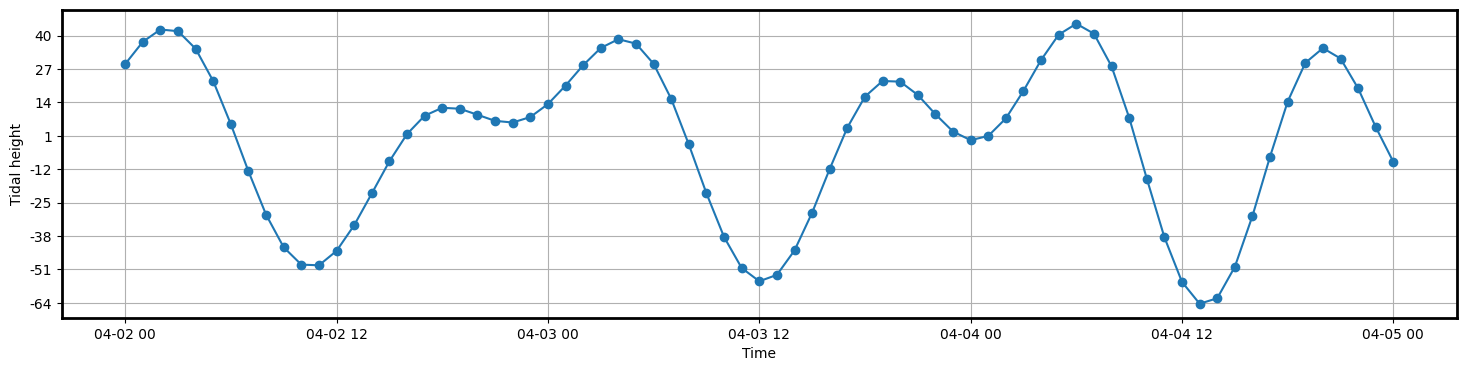

In [10]:
plot_tide_level(tide_level, dtime)

In [11]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'ATLAS-netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5-nc'

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)
#print(tpxo_curr_model)
#print(tpxo_curr_model.grid_file)
#print(tpxo_curr_model.model_file)

In [14]:
#if tpxo_curr_model:
model_files= tpxo_curr_model.model_file["u"]
print(model_files)
model_file = pathlib.Path(model_files[0]).expanduser()
hcx, cons = read_netcdf_transport(model_file, variable="u", compressed=False)
print(hcx.shape)
print(hcx)
print(hcx.mask)
tmp_mask = np.copy(hcx.mask)
tmp_mask[hcx.data==0j] = True
print(np.where(tmp_mask))

[PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/

In [17]:
consu = ATLAS.read_constants(
    tpxo_curr_model.grid_file, model_files, type='u', compressed=tpxo_curr_model.compressed)
print('model type is: ', type, ' constituents: ', consu)
print(consu.bathymetry)
print(consu.longitude)
print(consu.latitude)

model type is:  u  constituents:  q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm
[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 ...
 [4216.44042969 4216.44628906 4216.45117188 ... 4216.43554688
  4216.44042969 4216.44628906]
 [4215.85742188 4215.85839844 4215.86035156 ... 4215.85546875
  4215.85742188 4215.85839844]
 [4215.48828125 4215.48828125 4215.48828125 ... 4215.48828125
  4215.48828125 4215.48828125]]
[-1.66666654e-02  1.66666675e-02  5.00000005e-02 ...  3.59949996e+02
  3.59983329e+02  3.60016663e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]


(5401, 10802)


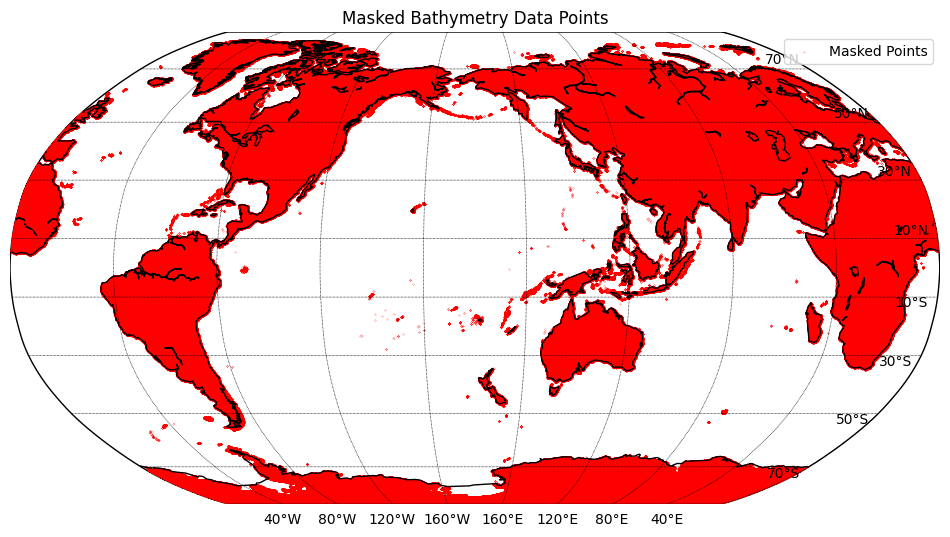

In [41]:
print(consu.mask.shape)
plot_model_mask(consu.mask[1:5401, 1:10801])

In [19]:
#Test code #refer zarr_fillna_ptx.ipynb ilat_idx = 1846, 4419 ilon_idx = 10083, 10577 
lon_idx = 23 #10350 #22 #9900 #11 #4950
lat_idx = 9  #4050 #4 #1800 #6 #2700
lon = lonz
lat = latz
bathymetry = bathy_z
tpxo_model = tpxo_curr_model
type = 'u'
cnt_chunk = 1
if True:
            start_lon = lon_range[lon_idx] #handle in lon_range #lon_range[lon_idx]+1 if global_grid else lon_range[lon_idx]
            end_lon = lon_range[lon_idx+1] #handle in lon_range #lon_range[lon_idx+1]+1 if global_grid else lon_range[lon_idx+1]
            start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]      
            print(lon[start_lon], lon[end_lon-1], lat[start_lat], lat[end_lat-1])
            # Extract amplitude and phase for the current chunk
            amp_chunk, ph_chunk = extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, #bathymetry, 
                                                tpxo_model, type,
                                                consu, cnt_chunk) #, global_grid, en_interpolate, interpolate_to)
            amp_chunk[amp_chunk.mask] = np.nan
            ph_chunk[ph_chunk.mask] = np.nan
            amp = amp_chunk.data
            ph = ph_chunk.data
            print(amp)
            print(ph)



345.03332943371277 359.999995931178 45.00000177986245 59.96666903849818
model type-chunk is:  u - 1


/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD/io/ATLAS.py:333: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


[[[ 0.65128184  3.79069999  1.58860833 ...  4.82152687  3.09783566
    1.79615519]
  [ 0.68924628  3.88623108  1.571819   ...  4.84811594  3.01637002
    1.80527467]
  [ 0.72307928  3.97742927  1.56564733 ...  4.86934516  2.91524495
    1.78625977]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]]

 [[ 0.65305688  3.97462771  1.72449788 ...  4.82439886  2.8222135
    1.55594325]
  [ 0.69031108  4.05976914  1.70946612 ...  4.84861706  2.7449259
    1.56504354]
  [ 0.72447014  4.14206304  1.70264394 ...  4.86898269  2.65247926
    1.55055369]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
        

In [ ]:
if True:
            amp_nan_coords = set(tuple(coord) for coord in np.argwhere(np.isnan(amp.data)))
            ph_nan_coords = set(tuple(coord) for coord in np.argwhere(np.isnan(ph.data)))
            print(list(amp_nan_coords)[0:10])
            print('----')
            print(list(ph_nan_coords)[0:10])
            nan_coords = list(amp_nan_coords.union(ph_nan_coords))

            valid_nan_coords = [
                (start_lat + i, start_lon + j) for i, j, k in nan_coords 
                if not bathymetry.mask[start_lat + i, start_lon + j] 
                   and bathymetry.data[start_lat + i, start_lon + j] > 0.0
            ]
            print('----')
            print(valid_nan_coords)

            clusters_to_recompute = filter_and_form_clusters(valid_nan_coords)
            print(clusters_to_recompute)

            for cluster_idx, cluster in enumerate(clusters_to_recompute):
                result = process_neighbors(cluster, lon, lat, tpxo_model, type, cluster_idx, len(clusters_to_recompute))
                proc_cluster_idx, proc_cluster_num, start_lat_cluster, end_lat_cluster, start_lon_cluster, end_lon_cluster, proc_type, new_amp, new_ph = result
                print("cluster_idx: ",cluster_idx, " replace na: ", new_amp)
                # Replace NaN values in original amp and ph with recomputed values
                for i, j in valid_nan_coords:
                    local_i = i - start_lat_cluster
                    local_j = j - start_lon_cluster
        
                    if np.isnan(amp[i, j]).any():
                        print("old i, j: ", i, '-', j, " for: ", amp[i, j], " by new: ", local_i, '-',  local_j, ' for: ', new_amp[local_i, local_j])
                        amp[i, j] = new_amp[local_i, local_j]
            
                    if np.isnan(ph[i, j]).any():
                        ph[i, j] = new_ph[local_i, local_j]



In [ ]:
ilon_idx = 10714
ilat_idx = 4386
start_lon = 10350
start_lat = 4050
print(amp[ilat_idx-start_lat, ilon_idx-start_lon])
print(ph[ilat_idx-start_lat, ilon_idx-start_lon])
ilon = lonz[ilon_idx]
ilat = latz[ilat_idx]
ampu, phu, _, _ = ATLAS.extract_constants(
        np.atleast_1d(ilon), np.atleast_1d(ilat),
        tpxo_model.grid_file,
        tpxo_model.model_file['u'], type='u', method='spline',
        scale=tpxo_model.scale, compressed=tpxo_model.compressed
    )
print(ampu)
print(phu)

In [47]:
#Test extract_parallel chunk
lon = lonz
lat = latz
chunk_size_lon = 15
chunk_size_lat = 15
grid_sz = 1/30
lon_range = list(range(0, len(lon), int(chunk_size_lon/grid_sz)))
if len(lon) not in lon_range:  # Ensure last element is included if it's not already
    lon_range.append(len(lon))

lat_range = range(0, len(lat), int(chunk_size_lat/grid_sz))
# lat length is 5401 not 5400
lat_range = list([x + 1 if x == 5400 else x for x in lat_range])
if len(lat) not in lat_range:
    lat_range.append(len(lat))

print(lon_range, lat_range)
lon_idx = len(lon_range)-2
lat_idx = int(len(lat_range)/2)
start_lon = lon_range[lon_idx]
end_lon = lon_range[lon_idx+1]
start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]
print(start_lon, end_lon, start_lat, end_lat)

[0, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5400, 5850, 6300, 6750, 7200, 7650, 8100, 8550, 9000, 9450, 9900, 10350, 10800] [0, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5401]
10350 10800 2700 3150


In [49]:
#From extract_Atlas_pytmd
type = 'u'
tide_model = tpxo_curr_model
if True:
    #print('model type-chunk is: ', type, '-', chunk_num)
    if type in ['u', 'v']:
        model_files = tide_model.model_file[type]
    else:
        model_files = tide_model.model_file

    lon_chunk = lon[start_lon:end_lon]
    lat_chunk = lat[start_lat:end_lat]
    lon_grid, lat_grid = np.meshgrid(lon_chunk, lat_chunk)

    # if type == 'z':
    # if constituents is None:
    #    constituents = ATLAS.read_constants(
    #        tide_model.grid_file, model_files, type=type, compressed=tide_model.compressed)
    print(lon_grid.ravel(), lat_grid.ravel())

    amp, ph, D = ATLAS.interpolate_constants(
        lon_grid.ravel(), lat_grid.ravel(),
        constituents, type=type, scale=tide_model.scale,
        method='spline', extrapolate=True)
    c = constituents
    print(len(c))
    # else:
    # amp, ph, D, c = ATLAS.extract_constants(
    #    lon_grid.ravel(), lat_grid.ravel(),
    #    tide_model.grid_file,
    #    model_files, type=type, method='spline',
    #    scale=tide_model.scale, compressed=tide_model.compressed)

    chunkx = end_lon - start_lon  # slicing is not include end_lon
    chunky = end_lat - start_lat
    amplitude = np.reshape(amp, (chunky, chunkx, len(c)))
    phase = np.reshape(ph, (chunky, chunkx, len(c)))

print(amplitude)
print(phase)

[345.03332943 345.06666277 345.0999961  ... 359.93332927 359.9666626
 359.99999593] [ 0.          0.          0.         ... 14.96666726 14.96666726
 14.96666726]


/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD/io/ATLAS.py:607: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


15
[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [1.700782668380717 10.232690288867095 5.847616876996201 ...
   5.8707570786956875 0.8897927333706048 0.23011893424933091]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [1.7008870367389535 10.2292526744953 5.846101760011238 ...
   5.868009714253917 0.8909131651945156 0.2292998197346579]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [1.7010685058280512 10.225820426621517 5.844367491532097 ...
   5.86518653945252 0.8921369578089854 0.22858159575783188]]

 ...

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- 

In [50]:
amp1, ph1, D1, c1 = ATLAS.extract_constants(
    lon_grid.ravel(), lat_grid.ravel(),
    tide_model.grid_file,
    model_files, type=type, method='spline',
    scale=tide_model.scale, compressed=tide_model.compressed)

amplitude1 = np.reshape(amp1, (chunky, chunkx, len(c1)))
phase1 = np.reshape(ph1, (chunky, chunkx, len(c1)))

print(amplitude1)
print(phase1)

/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD/io/ATLAS.py:333: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


[[[3.7954908814429182 19.19996518401114 11.265672682984741 ...
   8.949028048311026 1.405237566323979 0.7790055747182162]
  [3.766067749803879 19.08360962178389 11.204500946856639 ...
   8.917660486676409 1.399864847433048 0.7754423689558176]
  [3.7451803580482266 18.99292830057937 11.15264831539799 ...
   8.889941193502537 1.3956538066175252 0.7720701379063531]
  ...
  [1.704225265982983 10.251396218921895 5.862906274188954 ...
   5.886334980081087 0.8917887019485705 0.2303084695089994]
  [1.7029447384977943 10.244774748759285 5.856876633311402 ...
   5.880126278524232 0.8910261814098914 0.23020383746094197]
  [1.7007822903419234 10.232688423485238 5.847615240801364 ...
   5.870755844721623 0.8897924496618766 0.23011891422002909]]

 [[3.8217029083259644 19.282408267240807 11.298536958441897 ...
   8.961354373902438 1.4127884358904397 0.7803466415162212]
  [3.79191464626694 19.161241233842052 11.23362356884942 ...
   8.926339877739677 1.407012799705844 0.7765864518858411]
  [3.77000263

In [70]:
lonu, latu, bathy_u = read_netcdf_grid(tpxo_curr_model.grid_file, variable='u')
print(lonu)
print(latu)
print(lonu.shape)
print(latu.shape)
print(bathy_u.shape)

[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
(5401, 10800)


In [ ]:
"""
#read_netcdf_grid in ATLAS.py
#import netCDF4
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonu = fileID.variables['lon_u'][:].copy()
latu = fileID.variables['lat_u'][:].copy()
print(lonu)
print(latu)
print(lonu.shape)
print(latu.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_u = np.ma.zeros((ny,nx))
bathy_u.data[:,:] = fileID.variables['hu'][:,:].T
bathy_u.mask = (bathy_u.data == 0.0)
"""

In [26]:
# Adjust longitude and lat values as per convention
lonux = np.copy(lonu) #already in [0,360] # adjust_lon_lat(lonu, lonu)
    
# Determine if it's a global grid
dlon = lonux[1] - lonux[0]
#global_grid = np.isclose(lonux[-1] - lonux[0], 360.0 - dlon)
print(global_grid)
if global_grid:
    lonux = extend_array(lonux, dlon)
    bathy_ux = extend_matrix(bathy_u)
    
# create masks
bathy_ux.mask = (bathy_ux.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonux, latu)
#Du = spline_2d(lonux, latu, bathy_ux, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(bathy_ux.shape)


True
(5401, 10802)


In [582]:
#check value in bbox (-25, 25, -20, 30) => 335-340, 25-30 that has no values in u,v
pu = bathy_u[3450:3600, 10050:10200]
print(np.where(np.isnan(pu)))
print(np.where(pu.mask))
print(np.where(bathy_u.mask))


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([   0,    0,    0, ..., 5209, 5209, 5209]), array([   0,    1,    2, ..., 9823, 9824, 9825]))
(array([   0,    0,    0, ..., 5209, 5209, 5209]), array([   0,    1,    2, ..., 9824, 9825, 9826]))


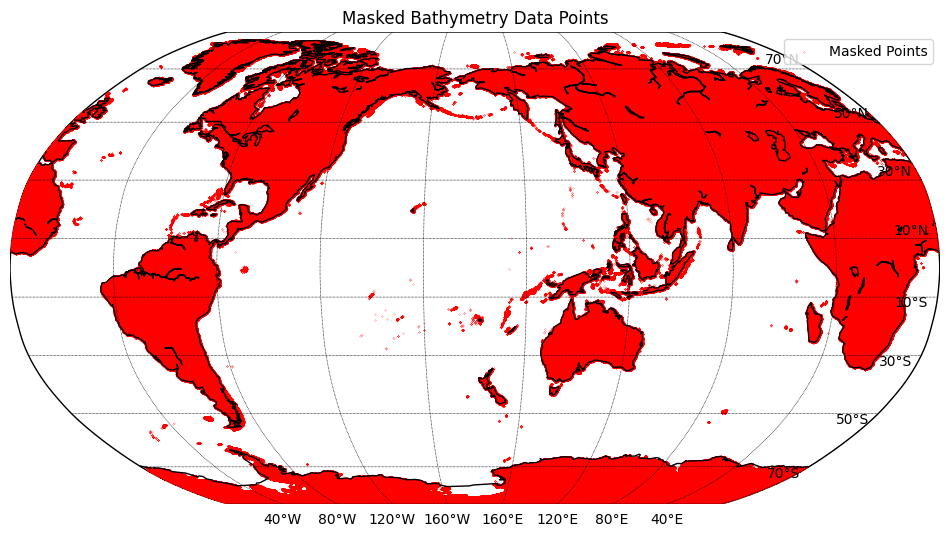

In [590]:
plot_model_mask(bathy_u.mask)

In [156]:
tolerance = 1e-9
def allIdentical(x, y, tolerance=1e-9):
    # Check if lon_u and lon_v are almost equal element-wise within the tolerance
    identicalx = np.allclose(x, y, atol=tolerance)

    if identicalx:
        print("The arrays are identical.")
        return None
    else:
        print("The arrays are not identical.")
        not_identical_mask = np.abs(x - y) > tolerance
        # Find the indices of elements that are not identical
        return np.where(not_identical_mask)

In [157]:
nlonidx = allIdentical(lonz, lonu)
nlatidx = allIdentical(latz, latu)
print(lonz[nlonidx])
print(lonu[nlonidx])

The arrays are not identical.
The arrays are identical.
[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]


In [28]:
lonv, latv, bathy_v = read_netcdf_grid(tpxo_curr_model.grid_file, variable='v')
print(lonv)
print(latv)
print(lonv.shape)
print(latv.shape)
print(bathy_v.shape)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]
(10800,)
(5401,)
(5401, 10800)


In [ ]:
"""
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonv = fileID.variables['lon_v'][:].copy()
latv = fileID.variables['lat_v'][:].copy()
print(lonv)
print(latv)
print(lonv.shape)
print(latv.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_v = np.ma.zeros((ny,nx))
bathy_v.data[:,:] = fileID.variables['hv'][:,:].T
bathy_v.mask = (bathy_v.data == 0.0)
"""

In [158]:
nlonidx = allIdentical(lonu, lonv)
nlatidx = allIdentical(latu, latv)
print(lonu[nlonidx])
print(lonv[nlonidx])
print("--------------------")
print(latu[nlatidx])
print(latv[nlatidx])


The arrays are not identical.
The arrays are not identical.
[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
--------------------
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]


In [26]:
# must rm -rf xx_chunks.zarr/
# global_grid = False
if global_grid:
    bathy = bathy_ux
    lonx = lonux
    #lat_chunk = 45
    en_interpolate = True
else: 
    bathy = bathy_u
    lonx = lonu
    #lat_chunk = 180
    en_interpolate = False

print(global_grid)
print(en_interpolate)
print(lonx)
print(chunk_file)

True
True
[-1.66666654e-02  1.66666675e-02  5.00000005e-02 ...  3.59949996e+02
  3.59983329e+02  3.60016663e+02]
tpxo9_chunks.zarr


In [ ]:
# must rm -rf xx_chunks.zarr/
# check ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
# cp -R tpxo9_chunkz.zarr/ tpxo9_chunks.zarr
# chunk_file = 'tpxo9_chunks.zarr' # setup in aboving global variable section
chunku = tpxo2zarr(lonx, latu, bathy, 'u_amp', 'u_ph',  tpxo_curr_model, 
                   xChunkSz, yChunkSz, grid_sz=1/30, 
                   chunk_file=chunk_file, type='u', mode="append_chunk", global_grid=global_grid,
                   en_interpolate=en_interpolate, interpolate_to=(lonz, latz, bathy_z))
print(chunku)

In [28]:
# Adjust longitude and lat values as per convention
lonvx = np.copy(lonv) #already in [0,360] # adjust_lon_lat(lonv, lonv)
    
# Determine if it's a global grid
dlon = lonvx[1] - lonvx[0]
print(global_grid)
#global_grid = np.isclose(lonvx[-1] - lonvx[0], 360.0 - dlon)
if global_grid:
    lonvx = extend_array(lonvx, dlon)
    bathy_vx = extend_matrix(bathy_v)
    
# create masks
bathy_vx.mask = (bathy_vx.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonvx, latv)
#Dv = spline_2d(lonvx, latv, bathy_vx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(bathy_vx.shape)
#print(Dv)

True
(5401, 10802)


In [579]:
print(np.where(np.isnan(bathy_v)))


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


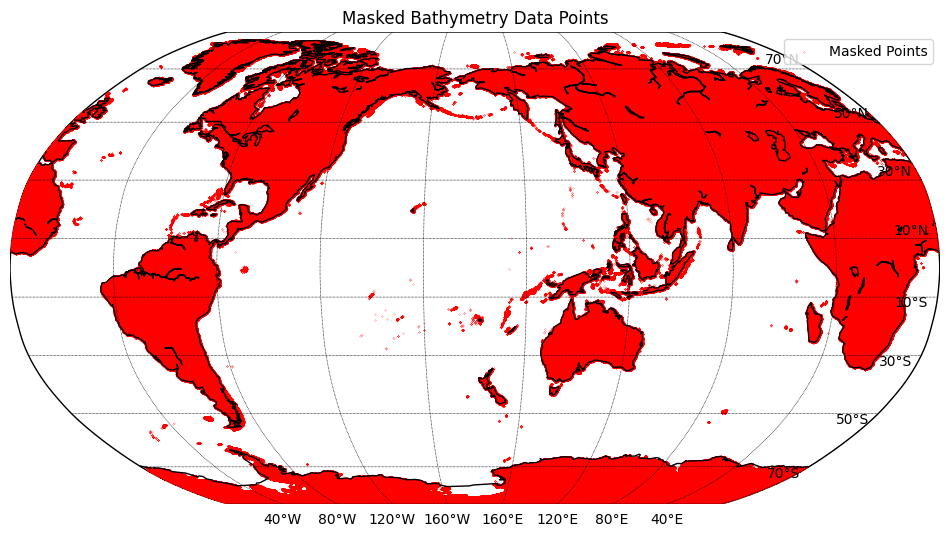

In [592]:
plot_model_mask(bathy_v[:,1:10801].mask)

In [29]:
# must rm -rf xx_chunks.zarr/
# global_grid = False
if global_grid:
    bathy = bathy_vx
    lonx = lonvx
    #lat_chunk = 45
    en_interpolate = True
else: 
    bathy = bathy_v
    lonx = lonv
    #lat_chunk = 180
    en_interpolate = False

print(en_interpolate)
print(lonx)

True
[1.05765477e-09 3.33333340e-02 6.66666670e-02 ... 3.59966663e+02
 3.59999996e+02 3.60033329e+02]


In [ ]:
#chunk_file = 'tpxo9_chunks.zarr'
chunkv = tpxo2zarr(lonx, latv, bathy, 'v_amp', 'v_ph',  tpxo_curr_model, 
                   xChunkSz, yChunkSz, grid_sz=1/30, 
                   chunk_file=chunk_file, type='v', mode="append_chunk", global_grid=global_grid, 
                   en_interpolate=en_interpolate, interpolate_to=(lonz, latz, bathy_z))
print(chunkv)

In [25]:
#ds_combined = xr.concat([xr.open_zarr(chunk_file, group=f"chunk_{i}") for i in range(chunkv)], dim='lat')
#chunk_size = 338
#ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
#ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


# This approach assumes that each chunk has the same size, except perhaps the last one in each dimension. It takes the chunks, organizes them in their proper 2D sequence, and then concatenates them in the correct order.
num_lat_chunks = len(lat_range) - 1
num_lon_chunks = len(lon_range) - 1

# 1. Organize the chunks into a 2D matrix
chunks_matrix = [[xr.open_zarr(chunk_file, group=f"chunk_{lat_idx*num_lon_chunks + lon_idx}") 
                  for lon_idx in range(num_lon_chunks)] 
                  for lat_idx in range(num_lat_chunks)]

# 2. Concatenate the chunks

# Concatenate chunks along the longitude for each latitude band
concat_along_lon = [xr.concat(lon_chunks, dim='lon') for lon_chunks in chunks_matrix]

# Now, concatenate the results along the latitude
ds_combined = xr.concat(concat_along_lon, dim='lat')

chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)

In [49]:
# move tpxo9.zarr to src/ to prevent it been written if do not want change before commit version change
dz1 = xr.open_zarr('../test/tmp_tpxo9.zarr', chunks='auto', decode_times=False)
print(dz1)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) object 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(338, 338, 15), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(338, 338, 15), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(338, 338, 15), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(338, 338, 15), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(338, 338, 15), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(338, 338, 15), meta=np.ndarray>


In [12]:
x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25  #127.866665222163, 22.4666675552795, 128, 23 
#x0, y0, x1, y1 = 122.26672, 23.76175, 129.75, 31.25 #123.5, 28 #to test v is empty bug 
#x0, y0, x1, y1 = 123.75, 23.76175, 129.75, 31.25
grid_sz = 1/30
uvsub = dz.sel(lon=slice(x0, x1+grid_sz), lat=slice(y0, y1+grid_sz))
#print(uvsub['u_amp'].values)
#print(uvsub['u_ph'].values)


In [26]:
# Before using 1e-4 as scale, original current_model.scale is 1e-2
# testsub = dz1.sel(lon=slice(x0, x1+grid_sz), lat=slice(y0, y1+grid_sz))
# test_curr = get_tide_map(testsub, tide_time[0:1])
# print(test_curr)

In [13]:
start_date = datetime(2023, 7, 25) #datetime(2024, 8, 4, 5, 30) #
end_date = datetime(2023, 7, 28) #datetime(2024, 8, 4, 7, 0) #


tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time)


[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [14]:
tide_curr = get_tide_map(uvsub, tide_time[0:1])
print(tide_curr)

{'u': masked_array(
  data=[[[0.2368085827922844],
         [0.25251193332883864],
         [0.2670736355461189],
         ...,
         [-0.40883422046026185],
         [-0.41017738741996007],
         [-0.4115729071436231]],

        [[0.22479423229602605],
         [0.24018735144040784],
         [0.25480796761725505],
         ...,
         [-0.40740441326223537],
         [-0.4090301570494885],
         [-0.4107032410527997]],

        [[0.20867940215039243],
         [0.22430076350131112],
         [0.23949052736950902],
         ...,
         [-0.4059888754607775],
         [-0.40789005571155296],
         [-0.409843450452843]],

        ...,

        [[--],
         [--],
         [--],
         ...,
         [-3.789311862434042],
         [-3.049096033552802],
         [-2.4849481501010193]],

        [[--],
         [--],
         [--],
         ...,
         [-4.500192679073102],
         [-3.670795303801037],
         [-2.97016822687918]],

        [[--],
         [--],
   

In [15]:
gtide = tide_curr
dsel = uvsub
# Set the time index (0 to 23)
t = 0
nx = dsel.coords['lon'].size
ny = dsel.coords['lat'].size
print(ny, nx)
glon, glat = np.meshgrid(dsel.coords['lon'].values, dsel.coords['lat'].values)

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t] #*0.01 #.reshape(ny, nx)
v0 = gtide['v'][:,:,t] #*0.01 #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)
print(magnitude)
print(u0)
print(v0)


# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude



n = 5
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]

339 353
[[0.2700555495481118 0.28546694754428437 0.2999220211494866 ...
  0.4106728146253111 0.4117688454515543 0.41293591922243184]
 [0.2540374521158663 0.2692748093699673 0.28383962427438264 ...
  0.4093102126772586 0.4106878733404026 0.41213059769272]
 [0.23454616209217125 0.2500585998119874 0.26515479589610597 ...
  0.4079630552050443 0.40961600728609804 0.4113378872766183]
 ...
 [-- -- -- ... 3.8959092725744076 3.3347347085362484 3.0292132220147874]
 [-- -- -- ... 4.526040255782379 3.80951488674948 3.3294109062952497]
 [-- -- -- ... 4.988609265526608 4.278792276271747 3.6695476344403324]]
[[0.2368085827922844 0.25251193332883864 0.2670736355461189 ...
  -0.40883422046026185 -0.41017738741996007 -0.4115729071436231]
 [0.22479423229602605 0.24018735144040784 0.25480796761725505 ...
  -0.40740441326223537 -0.4090301570494885 -0.4107032410527997]
 [0.20867940215039243 0.22430076350131112 0.23949052736950902 ...
  -0.4059888754607775 -0.40789005571155296 -0.409843450452843]
 ...
 [-- -

In [24]:
print(np.max(magnitude))
print(np.min(magnitude))
print(np.max(u0))
print(np.min(u0))
print(np.max(v0))
print(np.min(v0))
upercentiles = [1, 10, 20, 30, 40, 50, 75, 90, 99]
u0x = u0.data
u0x[u0.mask] = np.nan
u0x = np.absolute(u0x)
u0x[np.isinf(u0x)] = np.nan
print(u0x)
uvalues = np.nanpercentile(u0x, upercentiles)
print(uvalues)

# Print the results
for p, q in zip(upercentiles, uvalues):
    print(f"{p}th percentile: {q}")


largeu_indx = np.where(u0x > 5)
print(u0x[largeu_indx].shape)
print(len(u0x.ravel()))


40.976152290235724
0.6489046950998435
nan
nan
nan
nan
[[10.39592345 10.17358148  9.82322257 ...  4.53057783  4.48249329
   4.37944935]
 [11.63980991 11.69737214 11.70881393 ...  4.48548764  4.43904086
   4.33850059]
 [10.26820703 10.4357523  10.62967229 ...  4.44028335  4.39545316
   4.29739935]
 ...
 [        nan         nan         nan ...  2.71822763  2.71706503
   2.72495518]
 [        nan         nan         nan ...  2.6898998   2.68578232
   2.68710922]
 [        nan         nan         nan ...  2.66925134  2.66206653
   2.65578701]]
[ 0.6146674   1.66689397  2.28597185  2.69935722  3.04592164  3.40572349
  4.37059069  7.06867241 11.55397235]
1th percentile: 0.614667401691956
10th percentile: 1.6668939742863318
20th percentile: 2.2859718507415008
30th percentile: 2.699357224694843
40th percentile: 3.045921638593072
50th percentile: 3.405723487546127
75th percentile: 4.370590692746184
90th percentile: 7.06867241152407
99th percentile: 11.553972353337617
(442,)
2806


In [51]:
mvalues = np.nanpercentile(magnitude, upercentiles)
print(uvalues)

[ 0.05023851  0.55180809  0.9526891   1.18864065  1.54627504  2.10732503
  8.59647105 17.40789982 44.36525807]


/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [16]:
def plot_current_gradients(x, y, u, v, mag, label_time, magmax=50):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use boolean indexing to filter the data points whose magnitude is below magmax
    valid_indices = mag < magmax
    x = x[valid_indices]
    y = y[valid_indices]
    u = u[valid_indices]
    v = v[valid_indices]
    clipped_mag = mag[valid_indices]
    
    # Plotting, note the "angles" and "scale" parameters
    quiver = ax.quiver(x, y, u, v, clipped_mag, angles='xy', scale_units='xy',
                       scale=3, pivot='middle', width=0.003, cmap='jet')
    plt.colorbar(quiver, ax=ax, label='Current speed')
    
    ax.set_title('Tidal Currents at ' + str(label_time))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

In [17]:
#import matplotlib.colors as colors

def plot_current_map_gradients(x, y, u, v, mag, label_time, magmax=50):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the Basemap object
    lon_min, lon_max, lat_min, lat_max = np.min(
        x), np.max(x), np.min(y), np.max(y)

    # Round the min/max to the nearest 5 for setting ticks
    lon_start = int(5 * (lon_min // 5))
    # +1 to ensure the upper bound is included
    lon_end = int(5 * (lon_max // 5 + 1))

    lat_start = int(5 * (lat_min // 5))
    # +1 to ensure the upper bound is included
    lat_end = int(5 * (lat_max // 5 + 1))

    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, ax=ax, resolution='i')

    # Convert x, y to map projection coordinates
    # x_map, y_map = m(x, y)
    # Add coastlines
    m.drawcoastlines()

    # Add ticks for meridians and parallels
    parallels = range(lat_start, lat_end, 5)
    meridians = range(lon_start, lon_end, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, fontsize=10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, fontsize=10)

    # Plotting the tidal currents
    vmin_val = 0   # You can set to another value if needed
    vmax_val = magmax

    # Plotting the tidal currents
    valid_indices = mag < vmax_val

    # Make sure you're using the boolean mask to filter ALL arrays
    x = x[valid_indices]
    y = y[valid_indices]
    u = u[valid_indices]
    v = v[valid_indices]
    clipped_mag = mag[valid_indices]

    x_map, y_map = m(x, y)

    # Plotting the tidal currents
    quiver = m.quiver(x_map, y_map, u, v, clipped_mag, angles='xy', scale_units='dots',
                      scale=0.1, pivot='middle', width=0.003, cmap='jet')
    plt.colorbar(quiver, ax=ax, label='Current speed')

    ax.set_title('Tidal Currents at ' + str(label_time))
    ax.set_xlabel('Longitude', labelpad=30)  # Adjust labelpad as needed
    ax.set_ylabel('Latitude', labelpad=30)   # Adjust labelpad as needed

    plt.show()


In [21]:
def plot_mask_region(mask, start_lon, end_lon, start_lat, end_lat):
    # Modify lon and lat values to match the given bounds
    lon_values = np.linspace(start_lon, end_lon, mask.shape[1])
    lat_values = np.linspace(start_lat, end_lat, mask.shape[0])
    
    # Extracting coordinates where the mask is True
    lon_masked = lon_values[np.where(mask)[1]]
    lat_masked = lat_values[np.where(mask)[0]]
    
    fig, ax = plt.subplots(figsize=(12, 8))

    # Update the Basemap object to match the given bounds
    m = Basemap(projection='merc', llcrnrlat=start_lat, urcrnrlat=end_lat,
                llcrnrlon=start_lon, urcrnrlon=end_lon, lat_ts=20, ax=ax, resolution='i')
    
    x_masked, y_masked = m(lon_masked, lat_masked)
    
    m.drawcoastlines()
    parallels = np.arange(start_lat, end_lat, (end_lat-start_lat)/5.0)
    meridians = np.arange(start_lon, end_lon, (end_lon-start_lon)/5.0)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, fontsize=10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, fontsize=10)
    
    m.scatter(x_masked, y_masked, s=0.1, color='red', marker='.', label='Masked Points')
    
    ax.legend(loc='upper right')
    ax.set_title('Masked Bathymetry Data Points')
    plt.show()


3540 3892
3300 3638
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


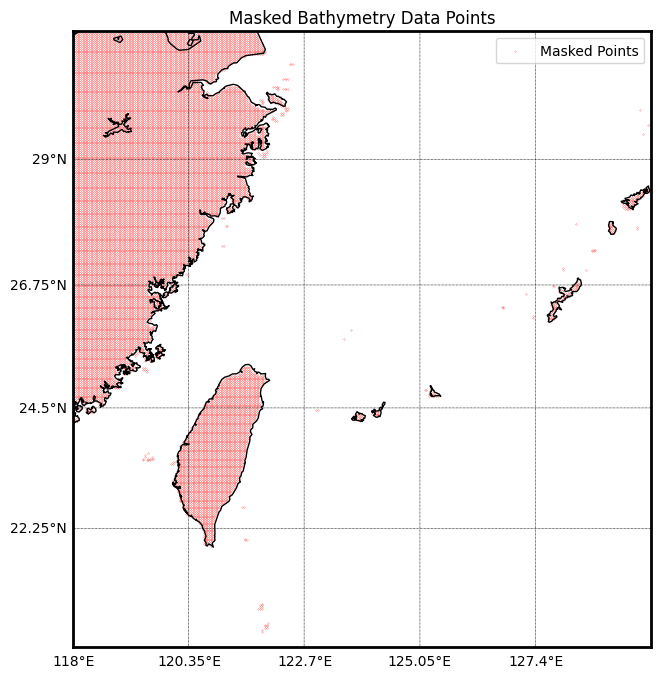

In [ ]:
#x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25 
#uvsub = dz.sel(lon=slice(x0-grid_sz, x1+grid_sz), lat=slice(y0-grid_sz, y1+grid_sz))
# Find the indices in the original 'lon' and 'lat' coordinates
lon_start_idx = np.where(dz.coords['lon'].values >= x0)[0][0]
lat_start_idx = np.where(dz.coords['lat'].values >= y0)[0][0]

lon_end_idx = np.where(dz.coords['lon'].values <= x1 + grid_sz)[0][-1]
lat_end_idx = np.where(dz.coords['lat'].values <= y1 + grid_sz)[0][-1]
print(lon_start_idx, lon_end_idx)
print(lat_start_idx, lat_end_idx)
print(bathy_u.mask[lat_start_idx:lat_end_idx+1, lon_start_idx:lon_end_idx+1])
plot_mask_region(bathy_u.mask[lat_start_idx:lat_end_idx+1, lon_start_idx:lon_end_idx+1], x0, x1, y0, y1)

In [18]:
x01, y01, u01, v01, mag01 = get_current_map(121, 22, 123, 23.5, dz, tide_time[0:1], mask_grid=1, normalize=True)

In [19]:
print(dtime[0])

2023-07-25 00:00:00


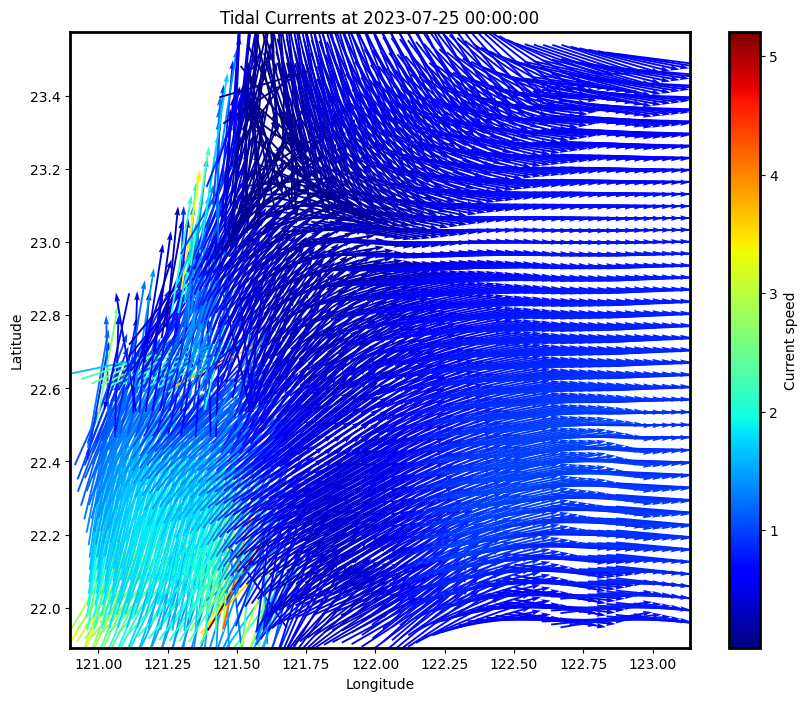

In [20]:
plot_current_gradients(x01, y01, u01, v01, mag01, dtime[0], magmax=500)

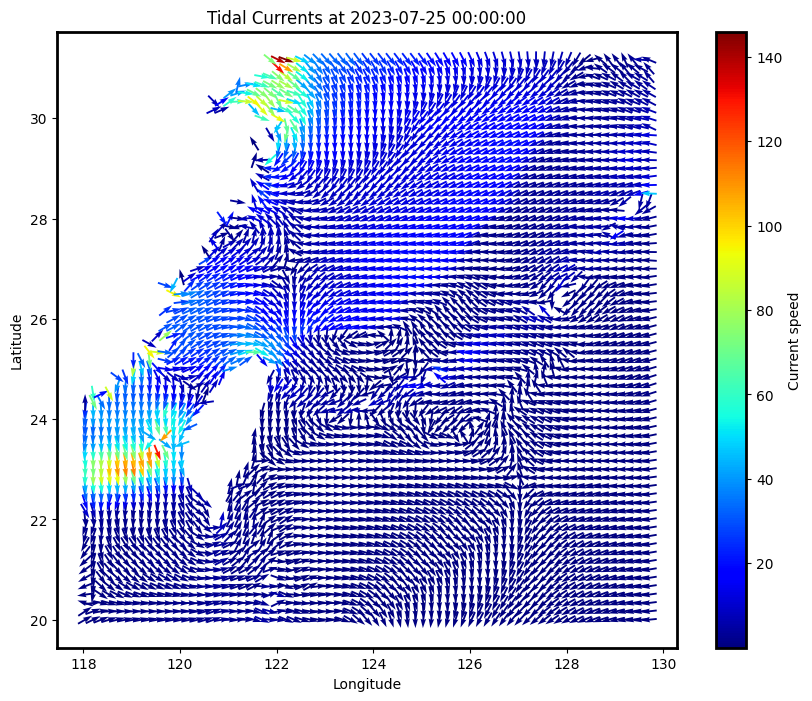

In [21]:
plot_current_gradients(x, y, u, v, mag, dtime[0], magmax=500)

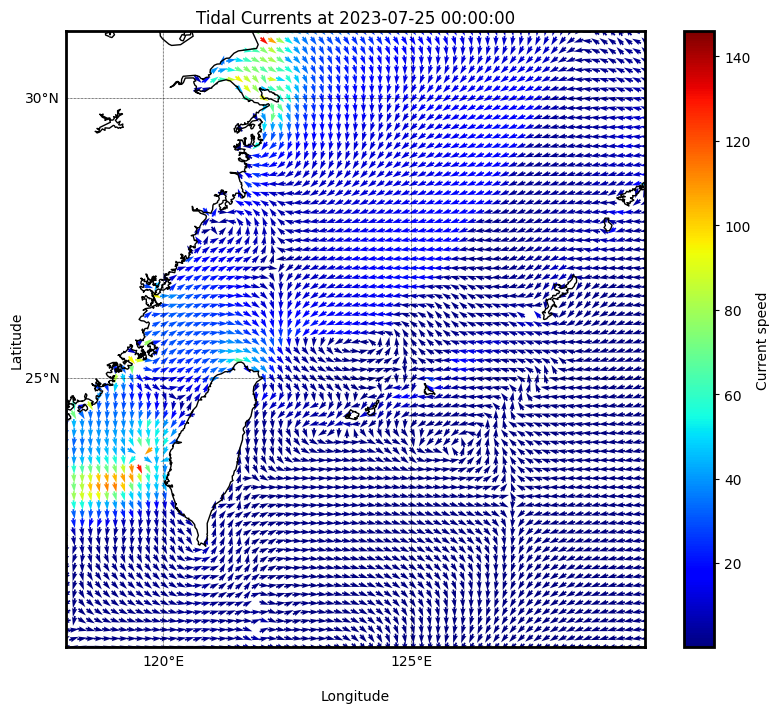

In [22]:
plot_current_map_gradients(x, y, u, v, mag, dtime[0], magmax=500)

In [ ]:
#just debugging...
subset_lon_values = uvsub.coords['lon'].values
subset_lat_values = uvsub.coords['lat'].values

# Get the original lon and lat values
original_lon_values = dz.coords['lon'].values
original_lat_values = dz.coords['lat'].values

# Find the start and end indices of the subset lon and lat in the original lon and lat
start_lon = np.where(original_lon_values == subset_lon_values[0])[0][0]
end_lon = np.where(original_lon_values == subset_lon_values[-1])[0][0] + 1 # +1 for slice not include end

start_lat = np.where(original_lat_values == subset_lat_values[0])[0][0]
end_lat = np.where(original_lat_values == subset_lat_values[-1])[0][0] + 1
print(start_lon, end_lon, start_lat, end_lat)
#print(bathy_v[start_lat:end_lat, start_lon:end_lon])
print(uvsub["v_amp"].values)
filled = uvsub.interpolate_na(['lon','lat'], method="spline")
print(filled["v_amp"].values)

3539 3893 3299 3639
[[[2.75463632e+01 1.54135058e+02 6.89684580e+01 ... 7.00784143e+00
   1.66799101e+00 7.84260409e-01]
  [2.76741392e+01 1.54957964e+02 6.91100266e+01 ... 7.05422621e+00
   1.59118726e+00 7.13374970e-01]
  [2.78002637e+01 1.55771371e+02 6.92456469e+01 ... 7.10312050e+00
   1.52111484e+00 6.45896296e-01]
  ...
  [4.20454706e+00 1.17926132e+01 7.47629988e+00 ... 2.87422981e+00
   5.25403695e-01 1.01964140e-01]
  [4.20468624e+00 1.18054053e+01 7.47545950e+00 ... 2.87540043e+00
   5.14118188e-01 1.01341244e-01]
  [4.20476415e+00 1.18203890e+01 7.47455020e+00 ... 2.87656807e+00
   5.03189820e-01 1.01477099e-01]]

 [[2.79353695e+01 1.56784669e+02 6.97696389e+01 ... 6.95269755e+00
   1.66884116e+00 8.14430814e-01]
  [2.80543157e+01 1.57487068e+02 6.98788563e+01 ... 7.00885519e+00
   1.59034117e+00 7.40334404e-01]
  [2.81696307e+01 1.58169056e+02 6.99765902e+01 ... 7.06874729e+00
   1.51861958e+00 6.71108848e-01]
  ...
  [4.21734401e+00 1.19248354e+01 7.50647116e+00 ... 2.864

In [23]:
start_date = datetime(2024, 8, 4, 5, 30) #
end_date = datetime(2024, 8, 4, 7, 0) #
tide_time, dtime = get_tide_time(start_date, end_date)
print(dtime[0])

2024-08-04 05:30:00


In [24]:
#North Atlantic
x1, y1, u1, v1, mag1 = get_current_map(280, 0, 360, 60, dz, tide_time[0:1], mask_grid=5)


In [ ]:
print(x1)
print(y1)
print(u1)
print(v1)

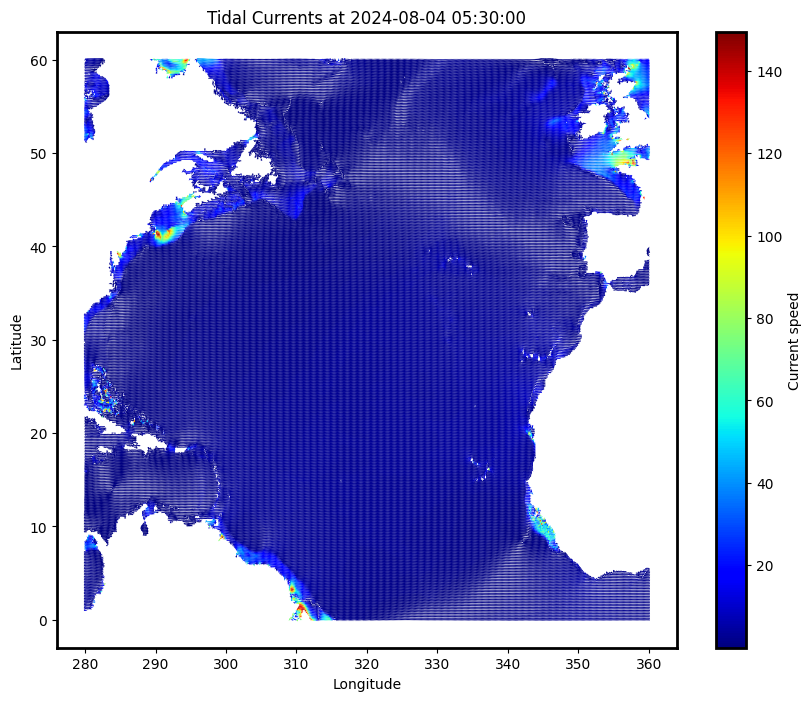

In [25]:
plot_current_gradients(x1, y1, u1, v1, mag1, dtime[0], magmax=150)

In [26]:
x1s, y1s, u1s, v1s, mag1s = get_current_map(320, 55, 330, 65, dz, tide_time[0:1], mask_grid=10)
print(u1s, v1s, mag1s)

[-0.19184992218425798 -0.25397100462688244 -0.33570714325069
 -0.3469784271059716 -0.3692183899610159 -0.40501237267498974
 -0.46602894953638796 -0.5217682827857443 -0.5270223781876857
 -0.5071910041496633 -0.5990314152315902 -0.7982614279289184
 -0.9259359917120111 -0.9824587421222224 -0.9710052826194988
 -0.9979642594324828 -0.9926058570272658 -0.9532243113706906
 -0.8671630473228915 -0.7820405264957193 -0.7693882873588704
 -0.7517478209002267 -0.7375479411164886 -0.7180223511308694
 -0.7112344611338065 -0.6981832108576556 -0.6649538452075644
 -0.6642173891368841 -0.6497698224047533 -0.6279989488548277
 -0.6198812176716714 -0.11117462020514234 -0.13791863907079227
 -0.21279519208569528 -0.2573053610249089 -0.280289070531574
 -0.34224565411767366 -0.40953842656871303 -0.4705378182553944
 -0.49120252890863475 -0.48974421405949126 -0.5961460411446489
 -0.7407919453802365 -0.8362268447892829 -0.9711450102194717
 -0.9649386024785593 -0.9914367554830874 -0.9978888907062681
 -0.967327152710

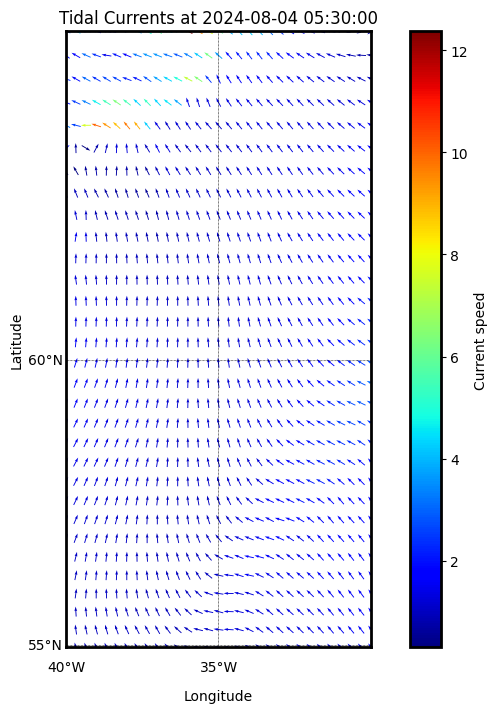

In [27]:
plot_current_map(x1s, y1s, u1s, v1s, mag1s, dtime[0])

In [ ]:
amp2u, ph2u, D2u = ATLAS.interpolate_constants(
    np.atleast_1d([325.0]), np.atleast_1d([60.0]),
    constituents, type='u', scale=tpxo_curr_model.scale,
    method='spline', extrapolate=True)

print(amp2u, ph2u, D2u)

In [ ]:
amp1u, ph1u, D1u, c1u = ATLAS.extract_constants(
    np.atleast_1d([325.0]), np.atleast_1d([60.0]),
    tpxo_curr_model.grid_file,
    model_files, type='u', method='spline',
    scale=tpxo_curr_model.scale, compressed=tpxo_curr_model.compressed)

print(amp1u, ph1u, D1u)

[[4.577453606343262 23.824310809958426 12.141767219612369
  29.56824363183195 55.59239432298688 265.8642189125532
  0.8313300238777714 97.34262634464447 26.232548342499335
  0.5104510675669001 0.6603042698393782 0.4634149042323588
  5.181917282969405 2.953279792176866 0.4694530000731972]] [[255.13736925779068 274.4409386825399 297.39464316201406
  290.5415660280926 15.091016103198033 40.00920593137286
  237.63866366083897 75.40937289006443 75.15324079618897
  328.05983612010766 65.41627337958052 262.18389783957446
  336.0003476717868 85.1551717412697 76.83486752079195]] [3006.909187591522]


In [ ]:
#u2 = np.copy(u1)*0.01
#v2 = np.copy(v1)*0.01
##mag2 = np.copy(mag1)*0.01
#u2[u2>200] = np.nan
#v2[v2>200] = np.nan
#mag2 = np.sqrt(u2**2 + v2**2)
#plot_current_map(x1, y1, u2, v2, mag2, dtime[0])


In [28]:
x1t, y1t, u1t, v1t, mag1t = get_current_map(330, 15, 359.9, 35, dz, tide_time[0:1], mask_grid=10)
print(u1t, v1t, mag1t)

[-0.11939740527408191 -0.1244370500667525 -0.12902240367117082 ... -- --
 --] [-0.9928465438393874 -0.9922275044417406 -0.9916416789097326 ... -- -- --] [2.879735065543444 2.861341008409232 2.836052642099108 ... -- -- --]


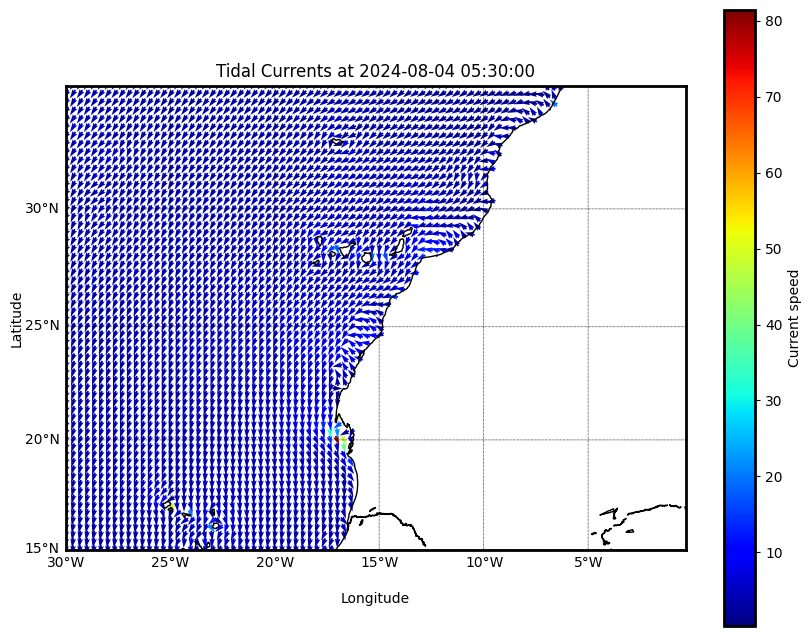

In [29]:
plot_current_map(x1t, y1t, u1t, v1t, mag1t, dtime[0])

In [ ]:
print(max(u1t), max(v1t), max(mag1t), np.argmax(mag1t))
tt = np.argmax(mag1t)
print(mag1t[tt])
print(u1t[tt], v1t[tt], np.sqrt(u1t[tt]**2 + v1t[tt]**2))

0.9999955802796544 0.9999677581751526 69.25101594382211 1389
69.25101594382211
0.9587408048897907 -0.28428167200731774 1.0


In [ ]:
#plot_current(x1t, y1t, u1t, v1t, mag1t, dtime[0])
#u2 = np.copy(u1t)*0.01
#v2 = np.copy(v1t)*0.01
#mag2 = np.copy(mag1)*0.01
#u2[u2>200] = np.nan
#v2[v2>200] = np.nan
#mag2 = np.sqrt(u2**2 + v2**2)
#plot_current_map(x1t, y1t, u2, v2, mag2, dtime[0])

In [30]:
x3, y3, u3, v3, mag3 = get_current_map(230, 30, 250, 45, dz, tide_time[0:1], mask_grid=5)

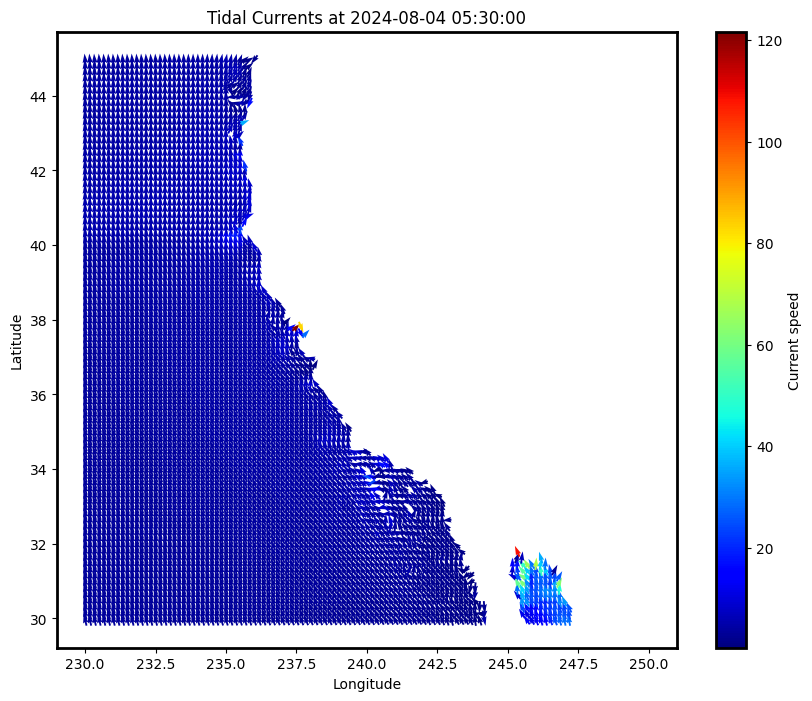

In [31]:
plot_current(x3, y3, u3, v3, mag3, dtime[0])

In [58]:
x4i, y4i, x4, y4 = 230, 30, 250, 45
grid_sz = 1/30
uvsub2 = dz.sel(lon=slice(x4i-grid_sz, x4+grid_sz), lat=slice(y4i-grid_sz, y4+grid_sz))
#print(uvsub['u_amp'].values)
#print(uvsub['u_ph'].values)


In [50]:
tide_curr2 = get_tide_map(uvsub2, tide_time[0:1])
print(tide_curr2)

{'u': masked_array(
  data=[[[-0.118873148153676],
         [-0.1204298873903293],
         [-0.12193839335273529],
         ...,
         [--],
         [--],
         [--]],

        [[-0.11985220188975416],
         [-0.1213208335583913],
         [-0.12273433664229455],
         ...,
         [--],
         [--],
         [--]],

        [[-0.12392612487113702],
         [-0.12546154195248935],
         [-0.12693248250786646],
         ...,
         [--],
         [--],
         [--]],

        ...,

        [[-0.24802042406099412],
         [-0.23658217318143976],
         [-0.2254231586577382],
         ...,
         [--],
         [--],
         [--]],

        [[-0.2594232322741252],
         [-0.24784581591640525],
         [-0.23651489011717364],
         ...,
         [--],
         [--],
         [--]],

        [[-0.27097133338655066],
         [-0.25925757057522725],
         [-0.24773085776044868],
         ...,
         [--],
         [--],
         [--]]],
  mask=[[[Fa

In [ ]:
gtide = tide_curr2
dsel = uvsub2
# Set the time index (0 to 23)
t = 0
nx = dsel.coords['lon'].size
ny = dsel.coords['lat'].size
print(ny, nx)
glon, glat = np.meshgrid(dsel.coords['lon'].values, dsel.coords['lat'].values)

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t] #.reshape(ny, nx)
v0 = gtide['v'][:,:,t] #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)
print(magnitude)
print(u0)
print(v0)


# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude



n = 5
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]

452 602
[[113.2697958177005 112.95900452476337 112.64993807909303 ... -- -- --]
 [114.00422847930145 113.64624377479733 113.2900651608463 ... -- -- --]
 [114.82759030952518 114.44995937433735 114.07416817669417 ... -- -- --]
 ...
 [237.63093585999826 237.28073403028898 236.94048915856297 ... -- -- --]
 [237.48661693759163 237.11104172342453 236.7453531310989 ... -- -- --]
 [237.26031228168634 236.87988037011743 236.50965808907873 ... -- -- --]]
[[-11.887314463073736 -12.042988555135622 -12.193838926368128 ... -- --
  --]
 [-11.985220110612186 -12.132082994559319 -12.273433342614027 ... -- --
  --]
 [-12.392612824385354 -12.546153717117564 -12.693248247423426 ... -- --
  --]
 ...
 [-24.802042160474773 -23.65821745259302 -22.542316160509028 ... -- -- --]
 [-25.942322584739497 -24.78458159369363 -23.65148927836757 ... -- -- --]
 [-27.09713307770219 -25.925757365999 -24.7730853444031 ... -- -- --]]
[[112.64430034155993 112.31519545407195 111.98802990258059 ... -- -- --]
 [113.3724773040659

In [ ]:
print(np.max(magnitude))
print(np.min(magnitude))
print(np.max(u0))
print(np.min(u0))
print(np.max(v0))
print(np.min(v0))
upercentiles = [1, 10, 20, 30, 40, 50, 75, 90, 99]
u0x = magnitude.data
u0x[magnitude.mask] = np.nan
u0x = np.absolute(u0x)
u0x[np.isinf(u0x)] = np.nan
print(u0x)
uvalues = np.nanpercentile(u0x, upercentiles)
print(uvalues)

# Print the results
for p, q in zip(upercentiles, uvalues):
    print(f"{p}th percentile: {q}")

4440.468903262599
0.4899695210664679
2828.9464530181076
-1562.292121661763
nan
nan
[[113.26979582 112.95900452 112.64993808 ...          nan          nan
           nan]
 [114.00422848 113.64624377 113.29006516 ...          nan          nan
           nan]
 [114.82759031 114.44995937 114.07416818 ...          nan          nan
           nan]
 ...
 [237.63093586 237.28073403 236.94048916 ...          nan          nan
           nan]
 [237.48661694 237.11104172 236.74535313 ...          nan          nan
           nan]
 [237.26031228 236.87988037 236.50965809 ...          nan          nan
           nan]]
[ 22.19754124 103.22383562 121.11873392 136.38333186 146.55957888
 161.72962548 236.23758384 275.44430115 626.62785369]
1th percentile: 22.197541238959673
10th percentile: 103.22383561782753
20th percentile: 121.11873392432928
30th percentile: 136.38333186300247
40th percentile: 146.55957888403609
50th percentile: 161.72962548028366
75th percentile: 236.23758383742413
90th percentile: 2

In [36]:
x3u, y3u, u3u, v3u, mag3u = get_current_map(100, 0, 150, 20, dz, tide_time[0:1], mask_grid=5)

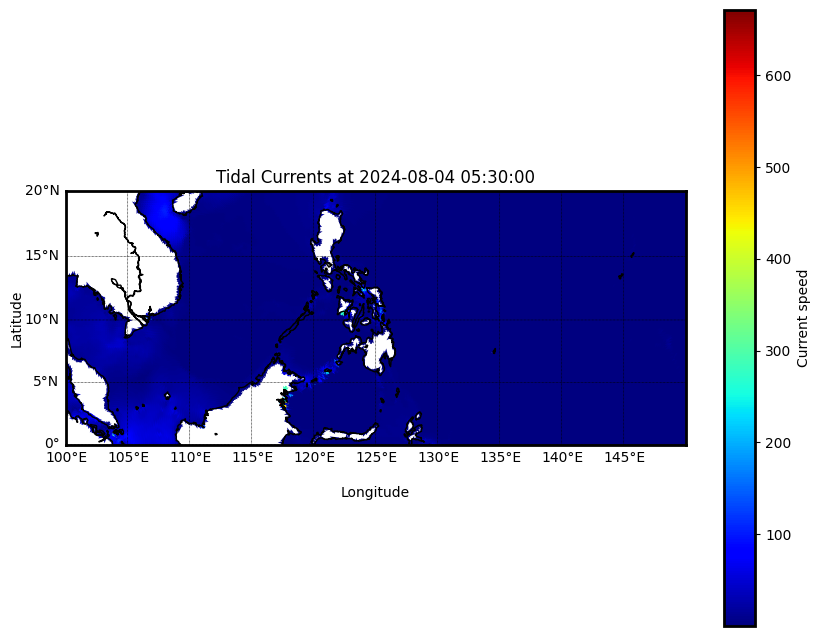

In [37]:
plot_current_map(x3u, y3u, u3u, v3u, mag3u, dtime[0])

In [32]:
x3i, y3i, u3i, v3i, mag3i = get_current_map(124.5, 10, 126.5, 14, dz, tide_time[0:1], mask_grid=1)

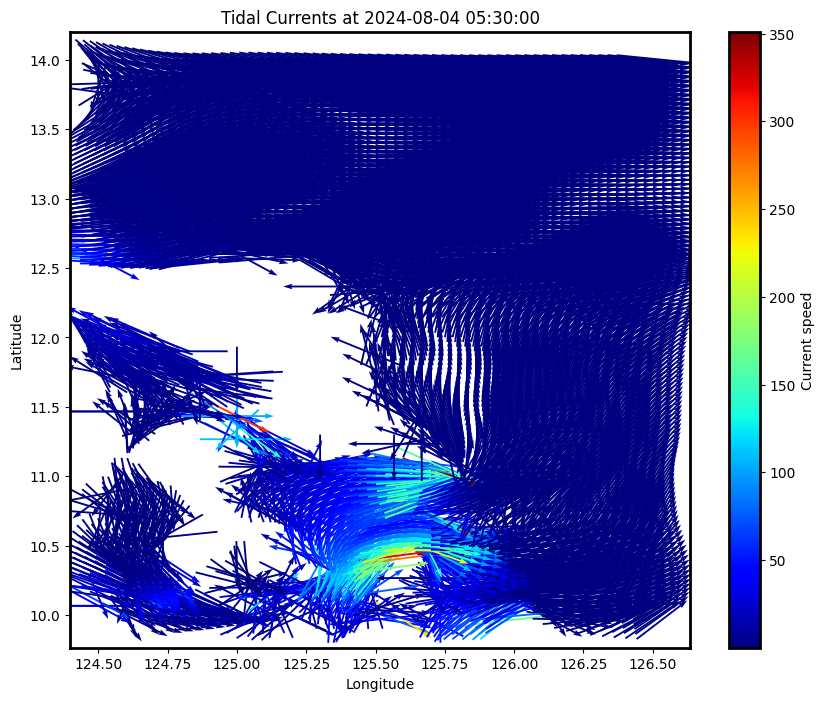

In [33]:
plot_current(x3i, y3i, u3i, v3i, mag3i, dtime[0])

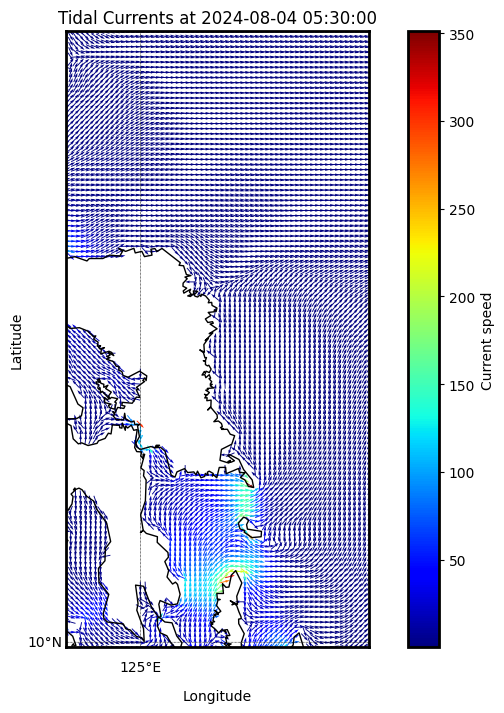

In [34]:
plot_current_map(x3i, y3i, u3i, v3i, mag3i, dtime[0])

In [35]:
#Indian Ocean
x2, y2, u2, v2, mag2 = get_current_map(100, -30, 150, 0, dz, tide_time[0:1], mask_grid=10)


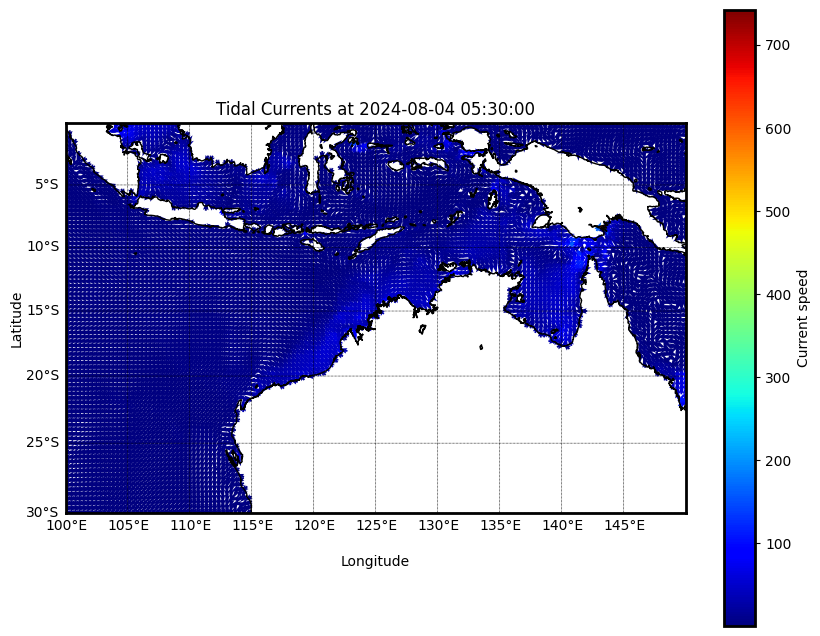

In [36]:
plot_current_map(x2, y2, u2, v2, mag2, dtime[0])

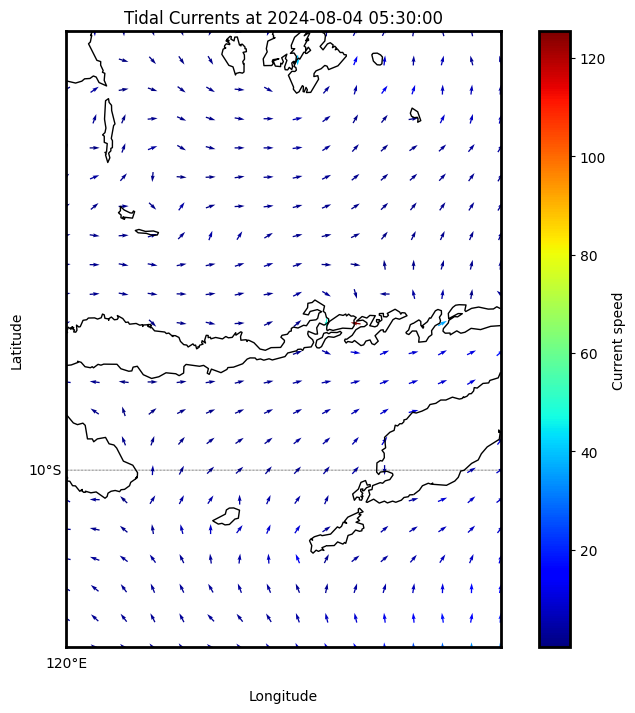

In [37]:
x2t, y2t, u2t, v2t, mag2t = get_current_map(120, -12, 125, -5, dz, tide_time[0:1], mask_grid=10)
plot_current_map(x2t, y2t, u2t, v2t, mag2t, dtime[0])

3600 3750
2341 2551
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


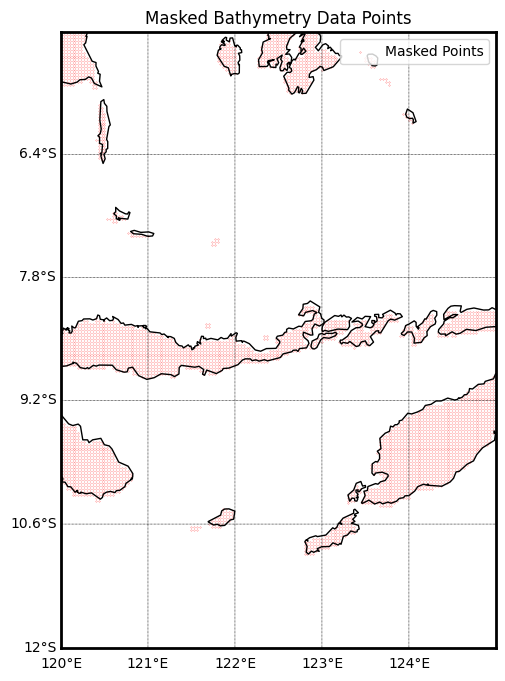

In [71]:
xt0, yt0, xt1, yt1 = 120, -12, 125, -5
lon_start_idx2 = np.where(dz.coords['lon'].values >= xt0)[0][0]
lat_start_idx2 = np.where(dz.coords['lat'].values >= yt0)[0][0]

lon_end_idx2 = np.where(dz.coords['lon'].values <= xt1 + grid_sz)[0][-1]
lat_end_idx2 = np.where(dz.coords['lat'].values <= yt1 + grid_sz)[0][-1]
print(lon_start_idx2, lon_end_idx2)
print(lat_start_idx2, lat_end_idx2)
print(bathy_u.mask[lat_start_idx2:lat_end_idx2+1, lon_start_idx2:lon_end_idx2+1])
plot_mask_region(bathy_u.mask[lat_start_idx2:lat_end_idx2+1, lon_start_idx2:lon_end_idx2+1], xt0, xt1, yt0, yt1)

In [ ]:
#Delete v_amp, v_ph chunks as the paralle-work broken suddenly
#import xarray as xr
Confirmed = False
if Confirmed:
    num_lat_chunks = len(lat_range) - 1
    num_lon_chunks = len(lon_range) - 1
    chunk_file = 'tpxo9_chunks.zarr'

    for lat_idx in range(num_lat_chunks):
        for lon_idx in range(num_lon_chunks):
            group_name = f"chunk_{lat_idx * num_lon_chunks + lon_idx}"
            ds_chunk = xr.open_zarr(chunk_file, group=group_name)

            # If the unwanted variables exist in the chunk, drop them
            vars_to_drop = [var for var in ['v_amp', 'v_ph'] if var in ds_chunk.variables]
            if vars_to_drop:
                ds_chunk = ds_chunk.drop_vars(vars_to_drop)

                # Write the modified chunk back to the Zarr store
                ds_chunk.to_zarr(chunk_file, group=group_name, mode='w', safe_chunks=False)


In [38]:
#Test https://github.com/jerabaul29/pyTMD/blob/feat/full-example/example/pytmd_script_use_get_tide_elevation_current.ipynb
lat_to_predict = 72.502
lon_to_predict = 19.560
start_day_to_predict = datetime(2008, 9, 10, 0, 0, 0, tzinfo=timezone.utc)
number_of_hours_to_predict = 24*8
list_datetimes_to_predict = [start_day_to_predict + timedelta(hours=hr) for hr in range(number_of_hours_to_predict)]
pytmd_times_to_predict = [convert_calendar_dates(crrt_time.year, crrt_time.month, crrt_time.day, crrt_time.hour, crrt_time.minute, crrt_time.second) for crrt_time in list_datetimes_to_predict]
print(pytmd_times_to_predict)

[6097.0, 6097.041666666511, 6097.083333333489, 6097.125, 6097.166666666511, 6097.208333333489, 6097.25, 6097.291666666511, 6097.333333333489, 6097.375, 6097.416666666511, 6097.458333333489, 6097.5, 6097.541666666511, 6097.583333333489, 6097.625, 6097.666666666511, 6097.708333333489, 6097.75, 6097.791666666511, 6097.833333333489, 6097.875, 6097.916666666511, 6097.958333333489, 6098.0, 6098.041666666511, 6098.083333333489, 6098.125, 6098.166666666511, 6098.208333333489, 6098.25, 6098.291666666511, 6098.333333333489, 6098.375, 6098.416666666511, 6098.458333333489, 6098.5, 6098.541666666511, 6098.583333333489, 6098.625, 6098.666666666511, 6098.708333333489, 6098.75, 6098.791666666511, 6098.833333333489, 6098.875, 6098.916666666511, 6098.958333333489, 6099.0, 6099.041666666511, 6099.083333333489, 6099.125, 6099.166666666511, 6099.208333333489, 6099.25, 6099.291666666511, 6099.333333333489, 6099.375, 6099.416666666511, 6099.458333333489, 6099.5, 6099.541666666511, 6099.583333333489, 6099.625

In [39]:
testsub = dz.sel(lon=slice(lon_to_predict, lon_to_predict+grid_sz),
                 lat=slice(lat_to_predict-grid_sz, lat_to_predict))
print(testsub)

<xarray.Dataset> Size: 916B
Dimensions:       (constituents: 15, lat: 1, lon: 1)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 8B 72.5
  * lon           (lon) float64 8B 19.57
Data variables:
    u_amp         (lat, lon, constituents) float64 120B dask.array<chunksize=(1, 1, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 120B dask.array<chunksize=(1, 1, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 120B dask.array<chunksize=(1, 1, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 120B dask.array<chunksize=(1, 1, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 120B dask.array<chunksize=(1, 1, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 120B dask.array<chunksize=(1, 1, 8), meta=np.ndarray>


In [40]:
testtide = get_tide_map(testsub, pytmd_times_to_predict)
print(testtide)

{'u': masked_array(data=[[[0.2558206408635038, -2.244653028553254,
                     -4.044374179918584, -4.78351778605302,
                     -4.339657703805484, -2.868229762511468,
                     -0.7847505235287062, 1.33015195244138,
                     2.8883387862520467, 3.4617338407648504,
                     2.896646263244049, 1.3391617826872027,
                     -0.8199510013148332, -3.0452303260138844,
                     -4.770208163930935, -5.513396517059905,
                     -4.992336231251009, -3.215994572905895,
                     -0.5166178717230256, 2.5122866236304353,
                     5.167301975090551, 6.825189862298795,
                     7.102067158228682, 5.933896530023864,
                     3.5732629498000503, 0.5264583319107765,
                     -2.5462207777329913, -4.960000707949491,
                     -6.160002391937442, -5.873020715570697,
                     -4.203107397969938, -1.6197179776771122,
                    

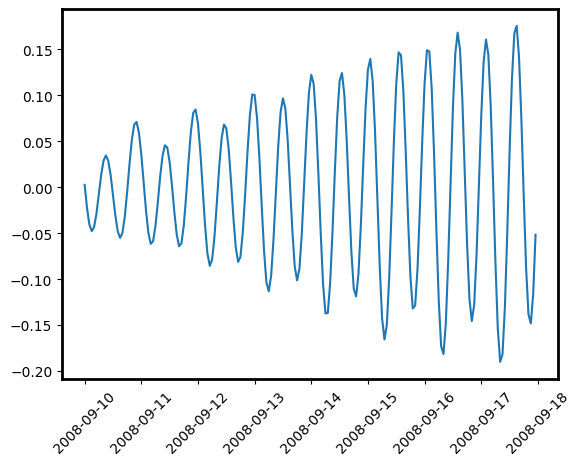

In [41]:
plt.figure()
plt.plot(list_datetimes_to_predict, testtide["u"].data[0,0,:]/100)
plt.xticks(rotation=45)
plt.show()

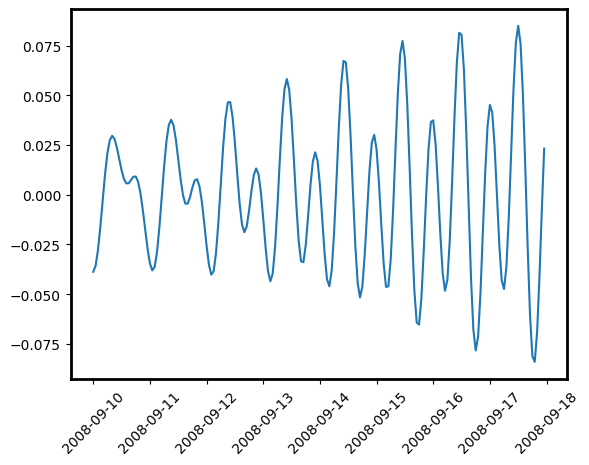

In [42]:
plt.figure()
plt.plot(list_datetimes_to_predict, testtide["v"].data[0,0,:]/100)
plt.xticks(rotation=45)
plt.show()

In [43]:
#10°S–15°N，105°–135°E
x5, y5, u5, v5, mag5 = get_current_map(105, -10, 135, 15, dz, tide_time[0:1], mask_grid=5)


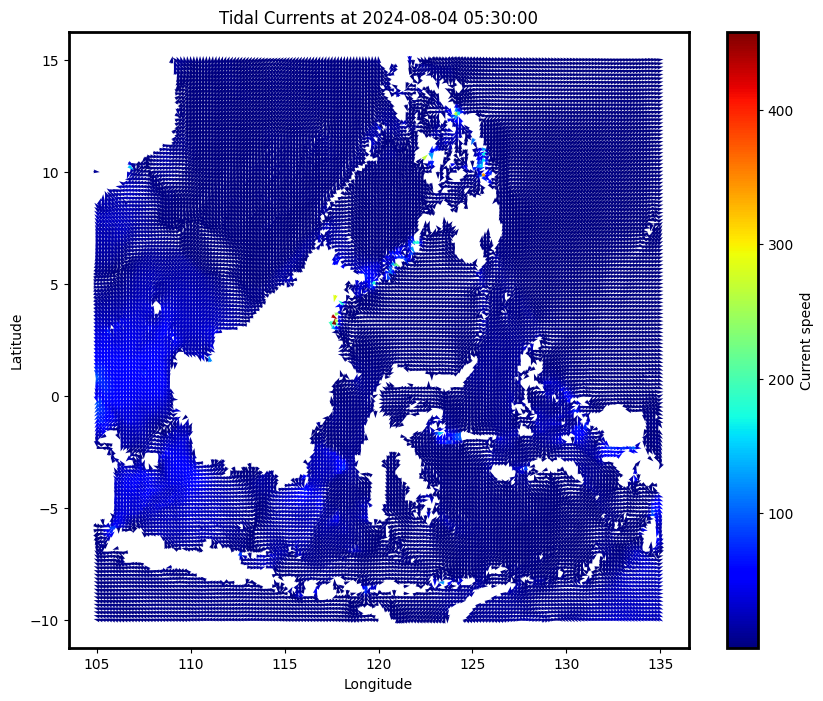

In [44]:
plot_current_gradients(x5, y5, u5, v5, mag5, dtime[0], magmax=500)

In [45]:
x5t, y5t, u5t, v5t, mag5t = get_current_map(115, -20, 140, 0, dz, tide_time[0:1], mask_grid=10)

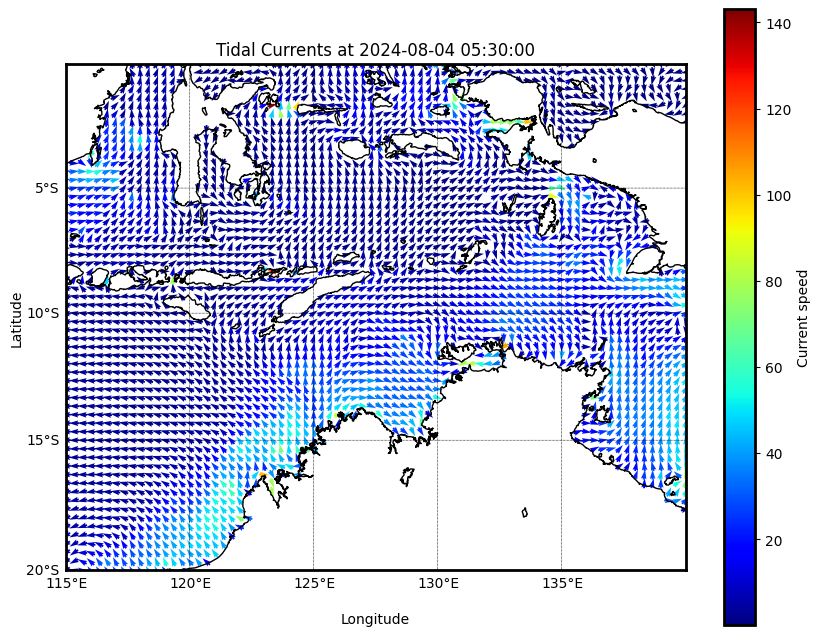

In [46]:
plot_current_map(x5t, y5t, u5t, v5t, mag5t, dtime[0]) #, magmax=300)